# Importing Libaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
from datetime import timedelta

# Libraries for model building
from scipy.stats.mstats     import winsorize
from sklearn.linear_model   import LogisticRegression 
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.svm            import SVC
from sklearn.tree           import DecisionTreeClassifier
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score

# Importing data

In [3]:
# Importing data

camp = pd.read_csv('../data/raw/campaigns.csv', sep=';')
donors = pd.read_csv('../data/raw/donors.csv', sep=',')
gifts = pd.read_csv('../data/raw/gifts.csv', sep=',')
sc6 = pd.read_csv('../data/raw/selection campaign 6169.csv')
sc7 = pd.read_csv('../data/raw/selection campaign 7244.csv')

In [4]:
# Basic exploration 
print("Donors shape:", donors.shape) 
print("Gifts shape:", gifts.shape) 
print("Campaign 6169 shape:", sc6.shape) 
print("Campaign 7244 shape:", sc7.shape)

Donors shape: (44691, 7)
Gifts shape: (216594, 4)
Campaign 6169 shape: (34888, 1)
Campaign 7244 shape: (25645, 1)


# References

In [5]:
rd1 = pd.to_datetime('2018-09-04') # date of 6169 campaign
rd2 = pd.to_datetime('2019-06-18') # date of 7244 campaign

# I/ Data description + Cleaning

## 1) Campaign

### General inspection

In [6]:
# Displaying the campaign table
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [7]:
# Displaying information
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


### Missing values and outliers

In [8]:
# Convert date to datetime
camp['date'] = pd.to_datetime(camp['date'])

/var/folders/h2/y6w_dvsj2mv412xb0cnmyvhc0000gn/T/ipykernel_32045/4099330542.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  camp['date'] = pd.to_datetime(camp['date'])


In [9]:
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6 873,"0,17 €"
1,154,2005-01-01,7 656,"0,30 €"
2,180,2005-01-18,9 933,"0,20 €"
3,433,2005-01-29,7 448,"0,59 €"
4,476,2005-02-12,6 605,"0,51 €"


In [10]:
# Convert the letterSent and cost per unit to a number
# To find outliers, we need to convert columns to integer before
# We use a raw string character that will find all types of whitespaces not just blanks
camp['lettersSent'] = (
    camp['lettersSent']
        .astype(str)
        .str.replace(r'\D+', '', regex=True)
        .astype(int)
)

camp['CostUnit'] = (
    camp['CostUnit']
        .astype(str)
        .str.replace(r'[^0-9,.-]', '', regex=True)
        .str.replace(',', '.', regex=False)
        .astype(float)
)
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   campaignID   367 non-null    int64         
 1   date         367 non-null    datetime64[ns]
 2   lettersSent  367 non-null    int64         
 3   CostUnit     367 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 11.6 KB


In [11]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(camp.isna().sum())
print('---------------------------------')
print(f'The data shows {camp.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
campaignID     0
date           0
lettersSent    0
CostUnit       0
dtype: int64
---------------------------------
The data shows 0 missing values


In [12]:
# Finding outliers (using only the numerical columns)
num_cols = camp.select_dtypes(include=['float', 'int']).columns.drop('campaignID')
# We define our boundaries
lower = camp[num_cols].quantile(0.01)
upper = camp[num_cols].quantile(0.99)

# printing the results
print('Lower bounds:\n',lower)
print('-------------------------')
print('Upper bounds:\n', upper)

Lower bounds:
 lettersSent    5243.66
CostUnit          0.02
Name: 0.01, dtype: float64
-------------------------
Upper bounds:
 lettersSent    47746.96
CostUnit           0.61
Name: 0.99, dtype: float64


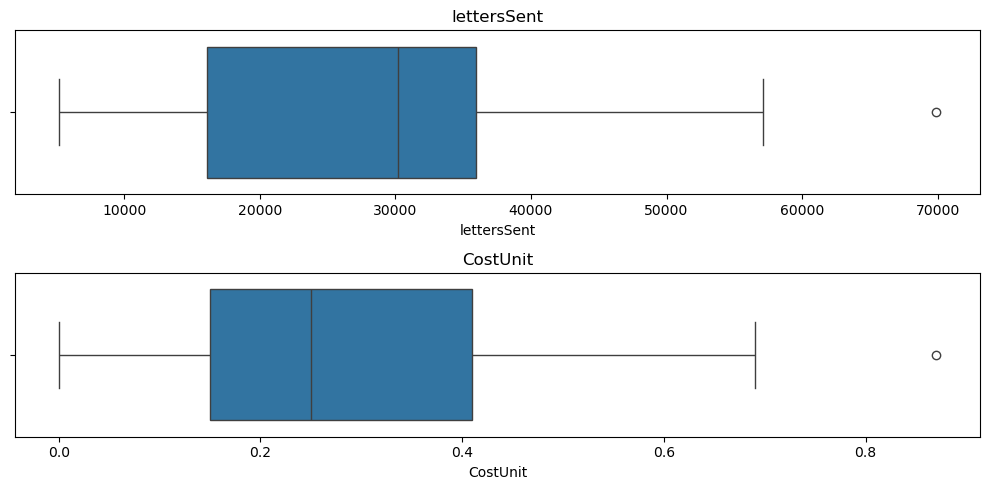

In [13]:
# Verifying outliers
# We use boxplots to identify potential outliers

fig, ax = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(10, 5))

for i, col in enumerate(num_cols):
    sns.boxplot(ax=ax[i], x=camp[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [14]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
camp = camp.copy()
camp[num_cols] = camp[num_cols].clip(lower=lower, upper=upper, axis=1)

In [15]:
# Verifying winsorization worked
for col in num_cols:
    print(col, 'min :', round(camp[col].min(),2))
    print(col, 'max :', round(camp[col].max(),2))

lettersSent min : 5243.66
lettersSent max : 47746.96
CostUnit min : 0.02
CostUnit max : 0.61


In [16]:
camp.head(2)

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6873.0,0.17
1,154,2005-01-01,7656.0,0.30


## 2) Donors

### General inspection

In [17]:
# Displaying the donors table
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,D100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,D100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,D100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,D100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [18]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donorID      44691 non-null  object 
 1   zipcode      44689 non-null  float64
 2   province     44691 non-null  object 
 3   region       44691 non-null  object 
 4   gender       44659 non-null  object 
 5   language     44691 non-null  object 
 6   dateOfBirth  44691 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.4+ MB


### Missing values and outliers

In [19]:
# Convert date to datetime
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

In [20]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(donors.isna().sum())
print('---------------------------------')
print(f'The data shows {donors.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID         0
zipcode         2
province        0
region          0
gender         32
language        0
dateOfBirth     0
dtype: int64
---------------------------------
The data shows 34 missing values


In [21]:
# Handling missing values

# zipcode
donors = donors.dropna(subset=['zipcode']) # since it represents only two observation and there is no other logical way to inpute them

# gender
gender_mode = donors['gender'].mode()[0]
donors['gender'] = donors['gender'].fillna(value=gender_mode) #filling by the mode seems relevant for this amount of data (32 out of 44 689 clients)

print(f'The data shows {donors.isna().sum().sum()} missing values now')

The data shows 0 missing values now


In [22]:
# Checking that there are indeed 44 689 different clients
donors.shape

(44689, 7)

In [23]:
donors.zipcode

0        1861.0
1        2260.0
2        1780.0
3        1020.0
4        1020.0
          ...  
44686    4900.0
44687    3600.0
44688    3061.0
44689    1950.0
44690    1160.0
Name: zipcode, Length: 44689, dtype: float64

In [24]:
# Zipcode was imported as float (e.g., 1180.0), but zipcodes are categorical labels
# We convert to integer to remove decimals, then to string so models don't treat it as numeric (which can mislead models)
donors['zipcode'] = donors['zipcode'].astype('Int64').astype(str)

In [25]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   donorID      44689 non-null  object        
 1   zipcode      44689 non-null  object        
 2   province     44689 non-null  object        
 3   region       44689 non-null  object        
 4   gender       44689 non-null  object        
 5   language     44689 non-null  object        
 6   dateOfBirth  44689 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 2.7+ MB


In [26]:
donors.head(2)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14


## 3) Gifts

### General inspection

In [27]:
# Displaying the gifts table
gifts.head()

,donorID,campaignID,amount,date
0,D100001,NaN,"12,39",23/03/2004
1,D100001,1577.0,"12,39",11/10/2007
2,D100001,1634.0,"6,69",28/12/2007
3,D100001,1778.0,"24,79",14/06/2008
4,D100001,1808.0,"7,44",09/07/2008


In [28]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     216594 non-null  object 
 1   campaignID  200957 non-null  float64
 2   amount      216594 non-null  object 
 3   date        216594 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.6+ MB


### Missing values and outliers

In [29]:
# Convert date to datetime
gifts['date'] = pd.to_datetime(gifts['date'])

# Be more specific
gifts = gifts.rename(columns={'date' : 'gift_date'})

/var/folders/h2/y6w_dvsj2mv412xb0cnmyvhc0000gn/T/ipykernel_32045/2177558126.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gifts['date'] = pd.to_datetime(gifts['date'])


In [30]:
# Convert amount to numeric
gifts['amount'] = (
    gifts['amount']
    .astype(str)
    .str.replace(".", "", regex=False)   # remove thousand separators
    .str.replace(",", ".", regex=False)  # convert decimal comma → dot
)
gifts['amount'] = pd.to_numeric(gifts['amount'], errors='coerce')



In [31]:
gifts.head()

,donorID,campaignID,amount,gift_date
0,D100001,NaN,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28
3,D100001,1778.0,24.79,2008-06-14
4,D100001,1808.0,7.44,2008-07-09


In [32]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(gifts.isna().sum())
print('---------------------------------')
print(f'The data shows {gifts.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID           0
campaignID    15637
amount           23
gift_date         0
dtype: int64
---------------------------------
The data shows 15660 missing values


In [33]:
gifts.campaignID = gifts.campaignID.fillna(value=0)
print(f'The data shows {gifts.isna().sum().sum()} missing values')

The data shows 23 missing values


Handling the missing ID's : 
- A missing ID means that a donation was NOT part of any campaign - it was a spontaneous donation
- This gives a valuable information and could be very useful for our models 
- Thus, we should keep them as they are 

In [34]:
gifts.head(3)

,donorID,campaignID,amount,gift_date
0,D100001,0.0,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28


In [35]:
gifts.sort_values(by = 'amount', ascending=False)

,donorID,campaignID,amount,gift_date
153012,D123168,0.0,4000000.00,2010-04-26
141895,D120861,1917.0,2479000.00,2008-11-17
150654,D122679,2417.0,30000.00,2010-07-04
182959,D130966,1377.0,12394.68,2007-04-21
21410,D102552,3785.0,5000.00,2014-05-03
...,...,...,...,...
139335,D120368,0.0,NaN,2006-10-18
139336,D120368,0.0,NaN,2006-12-03
172552,D128000,7005.0,NaN,2019-01-07
197762,D135598,3249.0,NaN,2012-07-26


In [36]:
amount_median = gifts.amount.median()

gifts.amount = gifts.amount.fillna(amount_median)

gifts.isna().sum()

donorID       0
campaignID    0
amount        0
gift_date     0
dtype: int64

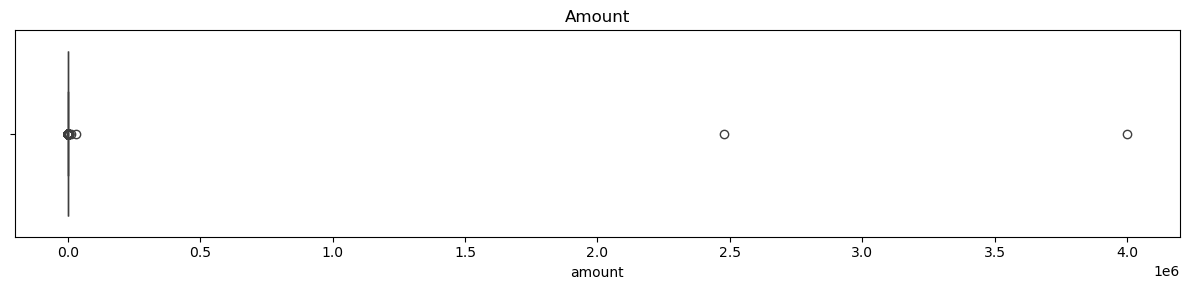

In [37]:
# Verifying outliers

fig, ax = plt.subplots(figsize=(12, 3))

sns.boxplot(x=gifts['amount'])
ax.set_title('Amount')

plt.tight_layout()
plt.show()

In [38]:
# Winsorizing the results
lower = gifts['amount'].quantile(0.01)
upper = gifts['amount'].quantile(0.99)

# printing the results
print(lower)
print(upper)

2.48
123.95


In [39]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
gifts = gifts.copy()
gifts['amount'] = gifts['amount'].clip(lower=lower, upper=upper*3)

In [40]:
gifts['amount'].max()

371.85

In [41]:
gifts.head(2)

,donorID,campaignID,amount,gift_date
0,D100001,0.0,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11


In [42]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   donorID     216594 non-null  object        
 1   campaignID  216594 non-null  float64       
 2   amount      216594 non-null  float64       
 3   gift_date   216594 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 6.6+ MB


## 4) Selection campaign 6169

### General inspection

In [43]:
# Displaying the sc6 table
sc6.head()

,donorID
0,D100001
1,D100002
2,D100004
3,D100008
4,D100009


### Missing values

In [44]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc6.isna().sum())
print('---------------------------------')
print(f'The data shows {sc6.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


## 5) selection campaign 7244

### General inspection

In [45]:
# Displaying the sc7 table
sc7.head()

,donorID
0,D100001
1,D100002
2,D100008
3,D100009
4,D100010


### Missing values

In [46]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc7.isna().sum())
print('---------------------------------')
print(f'The data shows {sc7.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


# II/ Dependent variables (train + validation set)

## 1) Train set

In [47]:
# Setting up the campaign date
campaign_date_6169 = rd1
campaign_date_6169

Timestamp('2018-09-04 00:00:00')

We need to define our gap period. A gap period is crucial as it allows the model to train, to send the campaign and avoid data leakage.
A one month Gap period is geenrally considered a standard in the industry

In [48]:
# Gap period: 1 week after campaign
gap_days = 7

In [49]:
# End of the gap period 
gap_end = campaign_date_6169 + timedelta(days = gap_days)
gap_end

Timestamp('2018-09-11 00:00:00')

In [50]:
#feature_cutoff_6169 = campaign_date_6169 - timedelta(gap_days)
#feature_cutoff_6169

We define our response window. This is the period where we will check if someone donated after the campaign. We will use a window of 60 days in order to gather meaningful results quickly

In [51]:
response_window = 60

In [52]:
post_campaign_train = gifts[(gifts['gift_date'] > gap_end) & (gifts['gift_date'] <= gap_end+timedelta(response_window))]

# We verify that the window is respected
print(post_campaign_train.gift_date.min())
print(post_campaign_train.gift_date.max())

2018-09-12 00:00:00
2018-11-08 00:00:00


In [53]:
post_campaign_train.head(3)

,donorID,campaignID,amount,gift_date
19,D100003,6922.0,4.0,2018-10-23
132,D100023,6169.0,15.0,2018-09-15
284,D100034,6170.0,45.0,2018-09-19


In [54]:
responses_train = post_campaign_train.groupby('donorID')['amount'].sum().reset_index()

responses_train.head(3)

,donorID,amount
0,D100003,4.0
1,D100023,15.0
2,D100034,45.0


In [55]:
sc6.head(2)

,donorID
0,D100001
1,D100002


In [56]:
sc6.shape

(34888, 1)

In [57]:
# Merging gifts and sc6 as gifts contains the donation history and we want to select those who were selected in the campaign

train_targets = sc6.merge(responses_train, on='donorID', how='left')
train_targets['amount'] = train_targets['amount'].fillna(0)
train_targets['target'] = (train_targets['amount'] >= 30).astype(int) # cast the values as binary, with >=30 = 1, else 0
train_targets = train_targets.drop(columns = 'amount')

train_targets.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100004,0
3,D100008,0
4,D100009,0


In [58]:
train_targets['target'].value_counts()

target
0    34123
1      765
Name: count, dtype: int64

In [59]:
train_targets.shape

(34888, 2)

## 2) Validation set

We follow the exact same steps and logic as we did before

In [60]:
campaign_date_7244 = rd2
campaign_date_7244

Timestamp('2019-06-18 00:00:00')

In [61]:
# End of the gap period 
gap_end = campaign_date_7244 + timedelta(days = gap_days)
gap_end

Timestamp('2019-06-25 00:00:00')

In [62]:
 # we use the same gap days as in the train table
#feature_cutoff_7244 = campaign_date_7244 - timedelta(gap_days)
#feature_cutoff_7244

In [63]:
# We also use the same response window as in the train table 
post_campaign_validation = gifts[(gifts['gift_date'] > gap_end) & (gifts['gift_date'] <= gap_end+timedelta(response_window))]

print(post_campaign_validation.gift_date.min())
print(post_campaign_validation.gift_date.max())

2019-06-26 00:00:00
2019-08-24 00:00:00


In [64]:
post_campaign_validation.head(3)

,donorID,campaignID,amount,gift_date
4042,D100548,0.0,50.0,2019-08-03
4780,D100607,0.0,4.0,2019-06-27
4781,D100607,0.0,4.0,2019-07-27


In [65]:
responses_validation = post_campaign_validation.groupby('donorID')['amount'].sum().reset_index()

responses_validation.head(3)

,donorID,amount
0,D100548,50.0
1,D100607,8.0
2,D100724,40.0


In [66]:
sc7.shape

(25645, 1)

In [67]:
# Merging gifts and sc6 as gifts contains the donation history and we want to select those who were selected in the campaign

validation_targets = sc7.merge(responses_validation, on='donorID', how='left')
validation_targets['amount'] = validation_targets['amount'].fillna(0)
validation_targets['target'] = (validation_targets['amount'] >= 30).astype(int) # cast the values as binary, with >=30 = 1, else 0
validation_targets = validation_targets.drop(columns = 'amount')

validation_targets.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100008,0
3,D100009,0
4,D100010,0


In [68]:
validation_targets['target'].value_counts()

target
0    25464
1      181
Name: count, dtype: int64

In [69]:
validation_targets.shape

(25645, 2)

# III/ Independent variable & basetable creation

## Training set

In [70]:
train_features = sc6.copy()

In [71]:
# Merge with donors table
train_features = train_features.merge(donors, on='donorID', how='left')

train_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14
2,D100004,1020,Brussels,Brussels,F,FR,1952-03-29


### Demographics

#### Age

In [72]:
# Calculate age at FEATURE CUTOFF date (Aug 5, 2018)
train_features["age"] = ( (campaign_date_6169.year - train_features["dateOfBirth"].dt.year))

# Fill missing ages with the median
train_features["age"] = train_features["age"].fillna(train_features["age"].median()).astype(int)

train_features.head(5)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,51
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,66
2,D100004,1020,Brussels,Brussels,F,FR,1952-03-29,66
3,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,81
4,D100009,1020,Brussels,Brussels,M,FR,1932-01-20,86


#### age_group

In [73]:
# Computing the age group

train_features['age_group'] = train_features['age'].apply(lambda x : 'youth' if x<=25 
                                                          else('adult' if x>25 and x<40 
                                                               else('middle_aged' if x>=40 and x<65 
                                                                    else'senior')))

train_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age,age_group
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,51,middle_aged
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,66,senior
2,D100004,1020,Brussels,Brussels,F,FR,1952-03-29,66,senior


#### Dealing with categorical varaibles

We have many categorical variables (objects) that need to be one hot encoded as per models requirements

In [74]:
# Selecting only the categorical variables 
obj_cols = train_features.select_dtypes(include='object').drop(columns='donorID').columns # exlude the donorID as it is not a feature
obj_cols

Index(['zipcode', 'province', 'region', 'gender', 'language', 'age_group'], dtype='object')

In [75]:
for col in obj_cols:
    print('Number of unique values in', col, ':', train_features[col].nunique())

Number of unique values in zipcode : 963
Number of unique values in province : 12
Number of unique values in region : 3
Number of unique values in gender : 2
Number of unique values in language : 3
Number of unique values in age_group : 4


In [76]:
# We first drop the zipcode varaiblea as it does not add any additional values given that we already have province and region
# One hot encoding is also impossible given the high number of unique values, this will pollute our models (eg. multicolinearity)

obj_cols = obj_cols.drop('zipcode')

train_features = train_features.drop(columns='zipcode')

'zipcode' in train_features

False

In [77]:
# 1. One-hot encode categorical variables
train_features = pd.get_dummies(
    train_features,
    columns=obj_cols,   # your list of categorical columns
    drop_first=True
)

# 2. Convert only the dummy columns (boolean → int)
bool_cols = train_features.select_dtypes(include="bool").columns
train_features[bool_cols] = train_features[bool_cols].astype(int)

train_features.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,province_Walloon Brabant,province_West Flanders,region_Flanders,region_Wallonia,gender_M,language_FR,language_NL,age_group_middle_aged,age_group_senior,age_group_youth
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,0,0,1,0,1,1,0,0,1,0
4,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0


In [78]:
train_features.shape

(34888, 22)

### Timing (RFM + LOR)

We first define our lookback days : our independent variables time window
- In theory we can take everything before the cutoff date that we defined earlier 
- However, we need to ensure that the train, validation and test tables have the same time window lenght
- Thus we need to define a lookback period that will be identical for all of them 

In [79]:
# We define our lookback days
lookback_days = 1825   # Coresponds to 5 years

# We define the start of our window given the lookback days
window_start_6169 = campaign_date_6169 - timedelta(lookback_days)

In [80]:
# Use only gifts BEFORE the feature cutoff (gap respected)
gifts_before_6169 = gifts[
    (gifts["gift_date"] >= window_start_6169) &
    (gifts["gift_date"] < campaign_date_6169) # TO VERIFY !!!! change ingap ?
].copy()

gifts_before_6169.head(3)

,donorID,campaignID,amount,gift_date
12,D100002,3941.0,20.0,2015-01-10
13,D100003,4801.0,5.0,2017-07-27
14,D100003,4830.0,3.0,2017-08-11


In [81]:
# We group by donor and compute donation history metrics
rfm_6169 = gifts_before_6169.groupby("donorID").agg(
    first_gift=("gift_date", "min"),
    last_gift=("gift_date", "max"),
    frequency=("amount", "count"),
    total_amount=("amount", "sum"),
    avg_amount=("amount", "mean"),
    max_amount=("amount", "max"),
    min_amount=("amount", "min")
).reset_index()

rfm_6169.head()

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount
0,D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0
1,D100003,2017-07-27,2018-07-08,5,18.0,3.600000,5.0,3.0
2,D100005,2016-10-26,2018-06-19,2,10.0,5.000000,5.0,5.0
3,D100006,2017-08-15,2017-08-15,1,5.0,5.000000,5.0,5.0
4,D100007,2014-05-13,2017-11-30,3,100.0,33.333333,40.0,30.0


In [82]:
# We compute RECENCY and TENURE
rfm_6169["recency_days"] = (campaign_date_6169 - rfm_6169["last_gift"]).dt.days

rfm_6169.head(3)

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,recency_days
0,D100002,2015-01-10,2015-01-10,1,20.0,20.0,20.0,20.0,1333
1,D100003,2017-07-27,2018-07-08,5,18.0,3.6,5.0,3.0,58
2,D100005,2016-10-26,2018-06-19,2,10.0,5.0,5.0,5.0,77


In [83]:
# Length Of Relationship (LOR) and history indicators
rfm_6169["LOR"] = (rfm_6169["last_gift"] - rfm_6169["first_gift"]).dt.days
rfm_6169["single_gift_in_window"] = (rfm_6169["frequency"] == 1).astype(int)
rfm_6169.loc[rfm_6169["single_gift_in_window"] == 1, "LOR"] = 0
rfm_6169["no_history"] = 0  # donors present here have at least one gift

rfm_6169.head(3)

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,recency_days,LOR,single_gift_in_window,no_history
0,D100002,2015-01-10,2015-01-10,1,20.0,20.0,20.0,20.0,1333,0,1,0
1,D100003,2017-07-27,2018-07-08,5,18.0,3.6,5.0,3.0,58,346,0,0
2,D100005,2016-10-26,2018-06-19,2,10.0,5.0,5.0,5.0,77,601,0,0


In [84]:
# Additional RFM and behavioral features (from Jules' notebook + enhancements)

# 1. Donation variability (standard deviation of gift amounts)
std_amount_6169 = gifts_before_6169.groupby("donorID")["amount"].std().reset_index()
std_amount_6169.columns = ["donorID", "std_amount"]
rfm_6169 = rfm_6169.merge(std_amount_6169, on="donorID", how="left")
rfm_6169["std_amount"] = rfm_6169["std_amount"].fillna(0)

# 2. Has ever donated >= 30 euros
donor_max_30_6169 = gifts_before_6169.groupby("donorID")["amount"].apply(lambda x: (x >= 30).any()).reset_index()
donor_max_30_6169.columns = ["donorID", "has_donated_30_plus"]
rfm_6169 = rfm_6169.merge(donor_max_30_6169, on="donorID", how="left")
rfm_6169["has_donated_30_plus"] = rfm_6169["has_donated_30_plus"].fillna(False).astype(int)

# 3. Percentage of donations >= 30 euros
pct_above_30_6169 = gifts_before_6169.groupby("donorID")["amount"].apply(lambda x: (x >= 30).sum() / len(x) if len(x) > 0 else 0).reset_index()
pct_above_30_6169.columns = ["donorID", "pct_donations_above_30"]
rfm_6169 = rfm_6169.merge(pct_above_30_6169, on="donorID", how="left")

# 4. Spontaneous donation rate (donations with campaignID = 0)
spontaneous_6169 = gifts_before_6169.groupby("donorID").apply(
    lambda x: (x["campaignID"] == 0).sum() / len(x) if len(x) > 0 else 0
).reset_index()
spontaneous_6169.columns = ["donorID", "spontaneous_donation_rate"]
rfm_6169 = rfm_6169.merge(spontaneous_6169, on="donorID", how="left")

# 5. Inside vs Outside campaign features
inside_campaign_6169 = gifts_before_6169[gifts_before_6169["campaignID"] != 0].groupby("donorID").agg(
    inside_campaign_amount=("amount", "sum"),
    inside_campaign_count=("amount", "count")
).reset_index()
rfm_6169 = rfm_6169.merge(inside_campaign_6169, on="donorID", how="left")

outside_campaign_6169 = gifts_before_6169[gifts_before_6169["campaignID"] == 0].groupby("donorID").agg(
    outside_campaign_amount=("amount", "sum"),
    outside_campaign_count=("amount", "count")
).reset_index()
rfm_6169 = rfm_6169.merge(outside_campaign_6169, on="donorID", how="left")

# Calculate ratios
rfm_6169["inside_campaign_amount"] = rfm_6169["inside_campaign_amount"].fillna(0)
rfm_6169["inside_campaign_count"] = rfm_6169["inside_campaign_count"].fillna(0)
rfm_6169["outside_campaign_amount"] = rfm_6169["outside_campaign_amount"].fillna(0)
rfm_6169["outside_campaign_count"] = rfm_6169["outside_campaign_count"].fillna(0)
rfm_6169["inside_campaign_ratio"] = rfm_6169["inside_campaign_amount"] / (rfm_6169["outside_campaign_amount"] + 1)

# 6. Average days between donations
def avg_days_between(group):
    if len(group) < 2:
        return np.nan
    dates = group.sort_values()
    return dates.diff().dt.days.mean()

avg_interval_6169 = gifts_before_6169.groupby("donorID")["gift_date"].apply(avg_days_between).reset_index()
avg_interval_6169.columns = ["donorID", "avg_days_between_donations"]
rfm_6169 = rfm_6169.merge(avg_interval_6169, on="donorID", how="left")

# 7. Standard deviation of days between donations (volatility)
def std_days_between(group):
    if len(group) < 2:
        return np.nan
    dates = group.sort_values()
    intervals = dates.diff().dt.days.dropna()
    return intervals.std() if len(intervals) > 0 else np.nan

std_interval_6169 = gifts_before_6169.groupby("donorID")["gift_date"].apply(std_days_between).reset_index()
std_interval_6169.columns = ["donorID", "std_days_between_donations"]
rfm_6169 = rfm_6169.merge(std_interval_6169, on="donorID", how="left")

# 8. Donation trend (slope of amount over time)
def donation_trend(group):
    if len(group) < 2:
        return 0
    group = group.sort_values("gift_date")
    x = np.arange(len(group))
    y = group["amount"].values
    if np.std(y) == 0:
        return 0
    slope = np.polyfit(x, y, 1)[0]
    return slope

trend_6169 = gifts_before_6169.groupby("donorID").apply(donation_trend).reset_index()
trend_6169.columns = ["donorID", "donation_trend"]
rfm_6169 = rfm_6169.merge(trend_6169, on="donorID", how="left")

# 9. Recency window features (30, 90, 365 days)
window_end_6169 = campaign_date_6169

# 30 days window
gifts_30d_6169 = gifts_before_6169[gifts_before_6169["gift_date"] >= (window_end_6169 - timedelta(days=30))]
rfm_30d_6169 = gifts_30d_6169.groupby("donorID").agg(
    frequency_30d=("amount", "count"),
    total_amount_30d=("amount", "sum"),
    last_gift_30d=("gift_date", "max")
).reset_index()
rfm_30d_6169["recency_30d"] = (window_end_6169 - rfm_30d_6169["last_gift_30d"]).dt.days
rfm_30d_6169 = rfm_30d_6169.drop(columns=["last_gift_30d"])
rfm_6169 = rfm_6169.merge(rfm_30d_6169, on="donorID", how="left")

# 90 days window
gifts_90d_6169 = gifts_before_6169[gifts_before_6169["gift_date"] >= (window_end_6169 - timedelta(days=90))]
rfm_90d_6169 = gifts_90d_6169.groupby("donorID").agg(
    frequency_90d=("amount", "count"),
    total_amount_90d=("amount", "sum"),
    last_gift_90d=("gift_date", "max")
).reset_index()
rfm_90d_6169["recency_90d"] = (window_end_6169 - rfm_90d_6169["last_gift_90d"]).dt.days
rfm_90d_6169 = rfm_90d_6169.drop(columns=["last_gift_90d"])
rfm_6169 = rfm_6169.merge(rfm_90d_6169, on="donorID", how="left")

# 365 days window
gifts_365d_6169 = gifts_before_6169[gifts_before_6169["gift_date"] >= (window_end_6169 - timedelta(days=365))]
rfm_365d_6169 = gifts_365d_6169.groupby("donorID").agg(
    frequency_365d=("amount", "count"),
    total_amount_365d=("amount", "sum"),
    last_gift_365d=("gift_date", "max")
).reset_index()
rfm_365d_6169["recency_365d"] = (window_end_6169 - rfm_365d_6169["last_gift_365d"]).dt.days
rfm_365d_6169 = rfm_365d_6169.drop(columns=["last_gift_365d"])
rfm_6169 = rfm_6169.merge(rfm_365d_6169, on="donorID", how="left")

rfm_6169.head(3)


/var/folders/h2/y6w_dvsj2mv412xb0cnmyvhc0000gn/T/ipykernel_32045/3169108187.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spontaneous_6169 = gifts_before_6169.groupby("donorID").apply(
/var/folders/h2/y6w_dvsj2mv412xb0cnmyvhc0000gn/T/ipykernel_32045/3169108187.py:82: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_6169 = gifts_before_6169.groupby("donorID").apply(donation_trend).reset_index()


,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,recency_days,LOR,...,donation_trend,frequency_30d,total_amount_30d,recency_30d,frequency_90d,total_amount_90d,recency_90d,frequency_365d,total_amount_365d,recency_365d
0,D100002,2015-01-10,2015-01-10,1,20.0,20.0,20.0,20.0,1333,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100003,2017-07-27,2018-07-08,5,18.0,3.6,5.0,3.0,58,346,...,-0.3,NaN,NaN,NaN,2.0,7.0,58.0,3.0,10.0,58.0
2,D100005,2016-10-26,2018-06-19,2,10.0,5.0,5.0,5.0,77,601,...,0.0,NaN,NaN,NaN,1.0,5.0,77.0,1.0,5.0,77.0


### Feature Engineering Summary

**Features ported from Jules' notebook:**
1. `std_amount` - Standard deviation of gift amounts (volatility measure)
2. `has_donated_30_plus` - Binary indicator: has donor ever given ≥€30
3. `pct_donations_above_30` - Percentage of donations that were ≥€30
4. `spontaneous_donation_rate` - Percentage of spontaneous donations (campaignID == 0)
5. `avg_days_between_donations` - Average days between consecutive donations
6. `donation_trend` - Slope of donation amounts over time (increasing/decreasing trend)

**New features created:**
7. **Inside vs Outside Campaign Features:**
   - `inside_campaign_amount`, `inside_campaign_count` - Total amount and count from campaign donations
   - `outside_campaign_amount`, `outside_campaign_count` - Total amount and count from spontaneous donations
   - `inside_campaign_ratio` - Ratio of inside/outside campaign amounts

8. **Recency Window Features (30, 90, 365 days):**
   - `frequency_30d`, `frequency_90d`, `frequency_365d` - Donation frequency in each window
   - `total_amount_30d`, `total_amount_90d`, `total_amount_365d` - Total amount in each window
   - `recency_30d`, `recency_90d`, `recency_365d` - Days since last gift in each window

9. **Volatility Features:**
   - `std_days_between_donations` - Standard deviation of days between donations (consistency measure)

**Timeline Compliance:**
- All features use only gifts BEFORE the campaign date (strictly < campaign_date)
- No data leakage - all features computed from historical data only
- Same 5-year lookback window (1825 days) for consistency


In [85]:
# Drop date columns (we already extracted useful info)
rfm_6169 = rfm_6169.drop(columns=["first_gift", "last_gift"])

In [86]:
# Merge into your existing feature table
train_features = train_features.merge(rfm_6169, on="donorID", how="left")

train_features.head(3)

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,donation_trend,frequency_30d,total_amount_30d,recency_30d,frequency_90d,total_amount_90d,recency_90d,frequency_365d,total_amount_365d,recency_365d
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
train_features.shape

(34888, 52)

### Campaign-specific

We need this to get 'CostUnit' associated with each gift, therefore, we will temporarily merge gifts and campaign data to get it. Indeed, gift is the only table that can link our basetable with campaign, since it has the campaignID key

In [88]:
print(gifts['campaignID'].dtype)
print(camp['campaignID'].dtype)


float64
int64


In [89]:
camp['campaignID'] = camp['campaignID'].astype(float)
gifts['campaignID'] = gifts['campaignID'].astype(float)

In [90]:
# Merge gifts with campaign metadata
gifts_with_costs = pd.merge(gifts, camp, on='campaignID', how='left')
gifts_with_costs.head(3)

,donorID,campaignID,amount,gift_date,date,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,NaT,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,2007-10-09,34636.0,0.31
2,D100001,1634.0,6.69,2007-12-28,2007-12-08,34080.0,0.21


In [91]:
# Restrict to the SAME lookback window as RFM
history_campaigns_6169 = gifts_with_costs[
    (gifts_with_costs["gift_date"] >= window_start_6169) &
    (gifts_with_costs["gift_date"] < campaign_date_6169)
].copy()

history_campaigns_6169.head(3)

,donorID,campaignID,amount,gift_date,date,lettersSent,CostUnit
12,D100002,3941.0,20.0,2015-01-10,2014-12-25,37833.00,0.50
13,D100003,4801.0,5.0,2017-07-27,2017-07-13,47746.96,0.21
14,D100003,4830.0,3.0,2017-08-11,2017-08-09,28955.00,0.19


In [92]:
# How expensive are the campaigns they support? (get an idea of their relative importance)
 # What is the importance of the campaign they support
campaign_features_6169 = history_campaigns_6169.groupby("donorID").agg(
    CostUnit_mean   = ("CostUnit", "mean"),
    CostUnit_min    = ("CostUnit", "min"),
    CostUnit_max    = ("CostUnit", "max"),
    lettersSent_mean= ("lettersSent", "mean")
).reset_index()

campaign_features_6169.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean
0,D100002,0.500,0.50,0.5,37833.000
1,D100003,0.196,0.07,0.3,35984.792
2,D100005,0.275,0.25,0.3,33251.000


In [93]:
# Cost range = variability in campaign cost
campaign_features_6169["CostUnit_range"] = (
    campaign_features_6169["CostUnit_max"] - campaign_features_6169["CostUnit_min"]
)

campaign_features_6169.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100002,0.500,0.50,0.5,37833.000,0.00
1,D100003,0.196,0.07,0.3,35984.792,0.23
2,D100005,0.275,0.25,0.3,33251.000,0.05


In [94]:
# Merging everything in one basetable

basetable_train = train_features.merge(campaign_features_6169, on="donorID", how="left")

basetable_train.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,total_amount_90d,recency_90d,frequency_365d,total_amount_365d,recency_365d,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.5,0.5,0.5,37833.0,0.0
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
basetable_train.columns

Index(['donorID', 'dateOfBirth', 'age', 'province_Antwerp',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'region_Flanders',
       'region_Wallonia', 'gender_M', 'language_FR', 'language_NL',
       'age_group_middle_aged', 'age_group_senior', 'age_group_youth',
       'frequency', 'total_amount', 'avg_amount', 'max_amount', 'min_amount',
       'recency_days', 'LOR', 'single_gift_in_window', 'no_history',
       'std_amount', 'has_donated_30_plus', 'pct_donations_above_30',
       'spontaneous_donation_rate', 'inside_campaign_amount',
       'inside_campaign_count', 'outside_campaign_amount',
       'outside_campaign_count', 'inside_campaign_ratio',
       'avg_days_between_donations', 'std_days_between_donations',
       'donation_trend', 'frequency_30d', 'total_amount_30d', '

In [96]:
# Adding some features

# 1) Average donation per letter received
basetable_train["amount_per_letter"] = (basetable_train["total_amount"] / (basetable_train["lettersSent_mean"] + 1))

# 2) Gifts per year relative to length of relationship in the window
basetable_train["gifts_per_year"] = (basetable_train["frequency"] / (basetable_train["LOR"] / 365 + 1))

# 3) Ratio of most recent max value vs average donation
basetable_train["current_value_ratio"] = (basetable_train["max_amount"] / (basetable_train["avg_amount"] + 1))

In [97]:
basetable_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   donorID                     34888 non-null  object        
 1   dateOfBirth                 34872 non-null  datetime64[ns]
 2   age                         34888 non-null  int64         
 3   province_Antwerp            34888 non-null  int64         
 4   province_Brussels           34888 non-null  int64         
 5   province_East Flanders      34888 non-null  int64         
 6   province_Flemish Brabant    34888 non-null  int64         
 7   province_Hainaut            34888 non-null  int64         
 8   province_Liege              34888 non-null  int64         
 9   province_Limburg            34888 non-null  int64         
 10  province_Luxembourg         34888 non-null  int64         
 11  province_Namur              34888 non-null  int64     

In [98]:
#basetable_train = basetable_train.drop(columns="dateOfBirth")   to drop later

In [99]:
basetable_train.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,total_amount_365d,recency_365d,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,NaN,NaN,0.5,0.5,0.5,37833.0,0.0,0.000529,1.0,0.952381
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
basetable_train.shape

(34888, 60)

## 2) Validation set

In [101]:
val_features = sc7.copy()

In [102]:
# Merge with donors table
val_features = val_features.merge(donors, on='donorID', how='left')

val_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14
2,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30


### a) demographic

#### age

In [103]:
# Calculate age at FEATURE CUTOFF date (Aug 5, 2018)
val_features["age"] = ( (campaign_date_7244.year - val_features["dateOfBirth"].dt.year))

# Fill missing ages with the median
val_features["age"] = val_features["age"].fillna(val_features["age"].median()).astype(int)

val_features.head(5)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,52
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,67
2,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,82
3,D100009,1020,Brussels,Brussels,M,FR,1932-01-20,87
4,D100010,1020,Brussels,Brussels,M,FR,1983-05-30,36


#### age_group

In [104]:
# Computing the age group

val_features['age_group'] = val_features['age'].apply(lambda x : 'youth' if x<=25 
                                                          else('adult' if x>25 and x<40 
                                                               else('middle_aged' if x>=40 and x<65 
                                                                    else'senior')))

val_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age,age_group
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,52,middle_aged
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,67,senior
2,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,82,senior


#### Dealing with categorical varaibles

We have many categorical variables (objects) that need to be one hot encoded as per models requirements

In [105]:
# Selecting only the categorical variables 
obj_cols = val_features.select_dtypes(include='object').drop(columns='donorID').columns # exlude the donorID as it is not a feature
obj_cols

Index(['zipcode', 'province', 'region', 'gender', 'language', 'age_group'], dtype='object')

In [106]:
for col in obj_cols:
    print('Number of unique values in', col, ':', val_features[col].nunique())

Number of unique values in zipcode : 939
Number of unique values in province : 12
Number of unique values in region : 3
Number of unique values in gender : 2
Number of unique values in language : 3
Number of unique values in age_group : 4


In [107]:
# We first drop the zipcode varaiblea as it does not add any additional values given that we already have province and region
# One hot encoding is also impossible given the high number of unique values, this will pollute our models (eg. multicolinearity)

obj_cols = obj_cols.drop('zipcode')

val_features = val_features.drop(columns='zipcode')

'zipcode' in val_features

False

In [108]:
# 1. One-hot encode categorical variables
val_features = pd.get_dummies(
    val_features,
    columns=obj_cols,   # your list of categorical columns
    drop_first=True
)

# 2. Convert only the dummy columns (boolean → int)
bool_cols = val_features.select_dtypes(include="bool").columns
val_features[bool_cols] = val_features[bool_cols].astype(int)

val_features.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,province_Walloon Brabant,province_West Flanders,region_Flanders,region_Wallonia,gender_M,language_FR,language_NL,age_group_middle_aged,age_group_senior,age_group_youth
0,D100001,1967-12-24,52,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1,D100002,1952-01-14,67,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
2,D100008,1937-08-30,82,0,0,0,1,0,0,0,...,0,0,1,0,1,1,0,0,1,0
3,D100009,1932-01-20,87,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
4,D100010,1983-05-30,36,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [109]:
val_features.shape

(25645, 22)

### Timing (RFM + LOR)

We first define our lookback days : our independent variables time window
- In theory we can take everything before the cutoff date that we defined earlier 
- However, we need to ensure that the train, validation and test tables have the same time window lenght
- Thus we need to define a lookback period that will be identical for all of them 

In [110]:
# We define our lookback days
lookback_days = 1825   # Coresponds to 5 years

# We define the start of our window given the lookback days
window_start_7244 = campaign_date_7244 - timedelta(lookback_days)

In [111]:
# Use only gifts BEFORE the feature cutoff (gap respected)
gifts_before_7244 = gifts[
    (gifts["gift_date"] >= window_start_7244) &
    (gifts["gift_date"] < campaign_date_7244) # TO VERIFY !!!! change ingap ?
].copy()

gifts_before_7244.head(3)

,donorID,campaignID,amount,gift_date
12,D100002,3941.0,20.0,2015-01-10
13,D100003,4801.0,5.0,2017-07-27
14,D100003,4830.0,3.0,2017-08-11


In [112]:
# We group by donor and compute donation history metrics
rfm_7244 = gifts_before_7244.groupby("donorID").agg(
    first_gift=("gift_date", "min"),
    last_gift=("gift_date", "max"),
    frequency=("amount", "count"),
    total_amount=("amount", "sum"),
    avg_amount=("amount", "mean"),
    max_amount=("amount", "max"),
    min_amount=("amount", "min")
).reset_index()

rfm_7244.head()

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount
0,D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0
1,D100003,2017-07-27,2019-06-17,12,46.0,3.833333,5.0,3.0
2,D100005,2016-10-26,2019-04-18,3,20.0,6.666667,10.0,5.0
3,D100006,2017-08-15,2017-08-15,1,5.0,5.000000,5.0,5.0
4,D100007,2015-08-18,2017-11-30,2,70.0,35.000000,40.0,30.0


In [113]:
# We compute RECENCY and TENURE
rfm_7244["recency_days"] = (campaign_date_7244 - rfm_7244["last_gift"]).dt.days

rfm_7244.head(3)

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,recency_days
0,D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0,1620
1,D100003,2017-07-27,2019-06-17,12,46.0,3.833333,5.0,3.0,1
2,D100005,2016-10-26,2019-04-18,3,20.0,6.666667,10.0,5.0,61


### Feature Engineering Summary (Validation Set)

Same features as training set, computed using validation campaign date (7244) and lookback window. All features maintain timeline compliance - only historical data before campaign date is used.


In [114]:
# Additional RFM and behavioral features (from Jules' notebook + enhancements)

# 1. Donation variability (standard deviation of gift amounts)
std_amount_7244 = gifts_before_7244.groupby("donorID")["amount"].std().reset_index()
std_amount_7244.columns = ["donorID", "std_amount"]
rfm_7244 = rfm_7244.merge(std_amount_7244, on="donorID", how="left")
rfm_7244["std_amount"] = rfm_7244["std_amount"].fillna(0)

# 2. Has ever donated >= 30 euros
donor_max_30_7244 = gifts_before_7244.groupby("donorID")["amount"].apply(lambda x: (x >= 30).any()).reset_index()
donor_max_30_7244.columns = ["donorID", "has_donated_30_plus"]
rfm_7244 = rfm_7244.merge(donor_max_30_7244, on="donorID", how="left")
rfm_7244["has_donated_30_plus"] = rfm_7244["has_donated_30_plus"].fillna(False).astype(int)

# 3. Percentage of donations >= 30 euros
pct_above_30_7244 = gifts_before_7244.groupby("donorID")["amount"].apply(lambda x: (x >= 30).sum() / len(x) if len(x) > 0 else 0).reset_index()
pct_above_30_7244.columns = ["donorID", "pct_donations_above_30"]
rfm_7244 = rfm_7244.merge(pct_above_30_7244, on="donorID", how="left")

# 4. Spontaneous donation rate (donations with campaignID = 0)
spontaneous_7244 = gifts_before_7244.groupby("donorID").apply(
    lambda x: (x["campaignID"] == 0).sum() / len(x) if len(x) > 0 else 0
).reset_index()
spontaneous_7244.columns = ["donorID", "spontaneous_donation_rate"]
rfm_7244 = rfm_7244.merge(spontaneous_7244, on="donorID", how="left")

# 5. Inside vs Outside campaign features
inside_campaign_7244 = gifts_before_7244[gifts_before_7244["campaignID"] != 0].groupby("donorID").agg(
    inside_campaign_amount=("amount", "sum"),
    inside_campaign_count=("amount", "count")
).reset_index()
rfm_7244 = rfm_7244.merge(inside_campaign_7244, on="donorID", how="left")

outside_campaign_7244 = gifts_before_7244[gifts_before_7244["campaignID"] == 0].groupby("donorID").agg(
    outside_campaign_amount=("amount", "sum"),
    outside_campaign_count=("amount", "count")
).reset_index()
rfm_7244 = rfm_7244.merge(outside_campaign_7244, on="donorID", how="left")

# Calculate ratios
rfm_7244["inside_campaign_amount"] = rfm_7244["inside_campaign_amount"].fillna(0)
rfm_7244["inside_campaign_count"] = rfm_7244["inside_campaign_count"].fillna(0)
rfm_7244["outside_campaign_amount"] = rfm_7244["outside_campaign_amount"].fillna(0)
rfm_7244["outside_campaign_count"] = rfm_7244["outside_campaign_count"].fillna(0)
rfm_7244["inside_campaign_ratio"] = rfm_7244["inside_campaign_amount"] / (rfm_7244["outside_campaign_amount"] + 1)

# 6. Average days between donations
def avg_days_between(group):
    if len(group) < 2:
        return np.nan
    dates = group.sort_values()
    return dates.diff().dt.days.mean()

avg_interval_7244 = gifts_before_7244.groupby("donorID")["gift_date"].apply(avg_days_between).reset_index()
avg_interval_7244.columns = ["donorID", "avg_days_between_donations"]
rfm_7244 = rfm_7244.merge(avg_interval_7244, on="donorID", how="left")

# 7. Standard deviation of days between donations (volatility)
def std_days_between(group):
    if len(group) < 2:
        return np.nan
    dates = group.sort_values()
    intervals = dates.diff().dt.days.dropna()
    return intervals.std() if len(intervals) > 0 else np.nan

std_interval_7244 = gifts_before_7244.groupby("donorID")["gift_date"].apply(std_days_between).reset_index()
std_interval_7244.columns = ["donorID", "std_days_between_donations"]
rfm_7244 = rfm_7244.merge(std_interval_7244, on="donorID", how="left")

# 8. Donation trend (slope of amount over time)
def donation_trend(group):
    if len(group) < 2:
        return 0
    group = group.sort_values("gift_date")
    x = np.arange(len(group))
    y = group["amount"].values
    if np.std(y) == 0:
        return 0
    slope = np.polyfit(x, y, 1)[0]
    return slope

trend_7244 = gifts_before_7244.groupby("donorID").apply(donation_trend).reset_index()
trend_7244.columns = ["donorID", "donation_trend"]
rfm_7244 = rfm_7244.merge(trend_7244, on="donorID", how="left")

# 9. Recency window features (30, 90, 365 days)
window_end_7244 = campaign_date_7244

# 30 days window
gifts_30d_7244 = gifts_before_7244[gifts_before_7244["gift_date"] >= (window_end_7244 - timedelta(days=30))]
rfm_30d_7244 = gifts_30d_7244.groupby("donorID").agg(
    frequency_30d=("amount", "count"),
    total_amount_30d=("amount", "sum"),
    last_gift_30d=("gift_date", "max")
).reset_index()
rfm_30d_7244["recency_30d"] = (window_end_7244 - rfm_30d_7244["last_gift_30d"]).dt.days
rfm_30d_7244 = rfm_30d_7244.drop(columns=["last_gift_30d"])
rfm_7244 = rfm_7244.merge(rfm_30d_7244, on="donorID", how="left")

# 90 days window
gifts_90d_7244 = gifts_before_7244[gifts_before_7244["gift_date"] >= (window_end_7244 - timedelta(days=90))]
rfm_90d_7244 = gifts_90d_7244.groupby("donorID").agg(
    frequency_90d=("amount", "count"),
    total_amount_90d=("amount", "sum"),
    last_gift_90d=("gift_date", "max")
).reset_index()
rfm_90d_7244["recency_90d"] = (window_end_7244 - rfm_90d_7244["last_gift_90d"]).dt.days
rfm_90d_7244 = rfm_90d_7244.drop(columns=["last_gift_90d"])
rfm_7244 = rfm_7244.merge(rfm_90d_7244, on="donorID", how="left")

# 365 days window
gifts_365d_7244 = gifts_before_7244[gifts_before_7244["gift_date"] >= (window_end_7244 - timedelta(days=365))]
rfm_365d_7244 = gifts_365d_7244.groupby("donorID").agg(
    frequency_365d=("amount", "count"),
    total_amount_365d=("amount", "sum"),
    last_gift_365d=("gift_date", "max")
).reset_index()
rfm_365d_7244["recency_365d"] = (window_end_7244 - rfm_365d_7244["last_gift_365d"]).dt.days
rfm_365d_7244 = rfm_365d_7244.drop(columns=["last_gift_365d"])
rfm_7244 = rfm_7244.merge(rfm_365d_7244, on="donorID", how="left")

rfm_7244.head(3)


/var/folders/h2/y6w_dvsj2mv412xb0cnmyvhc0000gn/T/ipykernel_32045/2614854533.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spontaneous_7244 = gifts_before_7244.groupby("donorID").apply(
/var/folders/h2/y6w_dvsj2mv412xb0cnmyvhc0000gn/T/ipykernel_32045/2614854533.py:82: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_7244 = gifts_before_7244.groupby("donorID").apply(donation_trend).reset_index()


,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,recency_days,std_amount,...,donation_trend,frequency_30d,total_amount_30d,recency_30d,frequency_90d,total_amount_90d,recency_90d,frequency_365d,total_amount_365d,recency_365d
0,D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0,1620,0.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100003,2017-07-27,2019-06-17,12,46.0,3.833333,5.0,3.0,1,0.577350,...,0.027972,1.0,4.0,1.0,3.0,12.0,1.0,8.0,31.0,1.0
2,D100005,2016-10-26,2019-04-18,3,20.0,6.666667,10.0,5.0,61,2.886751,...,2.500000,NaN,NaN,NaN,1.0,10.0,61.0,2.0,15.0,61.0


In [115]:
# Length Of Relationship (LOR) and history indicators
rfm_7244["LOR"] = (rfm_7244["last_gift"] - rfm_7244["first_gift"]).dt.days
rfm_7244["single_gift_in_window"] = (rfm_7244["frequency"] == 1).astype(int)
rfm_7244.loc[rfm_7244["single_gift_in_window"] == 1, "LOR"] = 0
rfm_7244["no_history"] = 0  # donors present here have at least one gift

rfm_7244.head(3)

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,recency_days,std_amount,...,recency_30d,frequency_90d,total_amount_90d,recency_90d,frequency_365d,total_amount_365d,recency_365d,LOR,single_gift_in_window,no_history
0,D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0,1620,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
1,D100003,2017-07-27,2019-06-17,12,46.0,3.833333,5.0,3.0,1,0.577350,...,1.0,3.0,12.0,1.0,8.0,31.0,1.0,690,0,0
2,D100005,2016-10-26,2019-04-18,3,20.0,6.666667,10.0,5.0,61,2.886751,...,NaN,1.0,10.0,61.0,2.0,15.0,61.0,904,0,0


In [116]:
# Drop date columns (we already extracted useful info)
rfm_7244 = rfm_7244.drop(columns=["first_gift", "last_gift"])

In [117]:
# Merge into your existing feature table
val_features = val_features.merge(rfm_7244, on="donorID", how="left")

val_features.head(3)

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,recency_30d,frequency_90d,total_amount_90d,recency_90d,frequency_365d,total_amount_365d,recency_365d,LOR,single_gift_in_window,no_history
0,D100001,1967-12-24,52,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,67,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0
2,D100008,1937-08-30,82,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
val_features.shape

(25645, 52)

### Campaign-specific

We need this to get 'CostUnit' associated with each gift, therefore, we will temporarily merge gifts and campaign data to get it. Indeed, gift is the only table that can link our basetable with campaign, since it has the campaignID key

In [119]:
print(gifts['campaignID'].dtype)
print(camp['campaignID'].dtype)

float64
float64


In [120]:
camp['campaignID'] = camp['campaignID'].astype(float)
gifts['campaignID'] = gifts['campaignID'].astype(float)

In [121]:
# Merge gifts with campaign metadata
gifts_with_costs = pd.merge(gifts, camp, on='campaignID', how='left')
gifts_with_costs.head(3)

,donorID,campaignID,amount,gift_date,date,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,NaT,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,2007-10-09,34636.0,0.31
2,D100001,1634.0,6.69,2007-12-28,2007-12-08,34080.0,0.21


In [122]:
# Restrict to the SAME lookback window as RFM
history_campaigns_7244 = gifts_with_costs[
    (gifts_with_costs["gift_date"] >= window_start_7244) &
    (gifts_with_costs["gift_date"] < campaign_date_7244)
].copy()

history_campaigns_7244.head(3)

,donorID,campaignID,amount,gift_date,date,lettersSent,CostUnit
12,D100002,3941.0,20.0,2015-01-10,2014-12-25,37833.00,0.50
13,D100003,4801.0,5.0,2017-07-27,2017-07-13,47746.96,0.21
14,D100003,4830.0,3.0,2017-08-11,2017-08-09,28955.00,0.19


In [123]:
# How expensive are the campaigns they support? (get an idea of their relative importance)
 # What is the importance of the campaign they support
campaign_features_7244 = history_campaigns_7244.groupby("donorID").agg(
    CostUnit_mean   = ("CostUnit", "mean"),
    CostUnit_min    = ("CostUnit", "min"),
    CostUnit_max    = ("CostUnit", "max"),
    lettersSent_mean= ("lettersSent", "mean")
).reset_index()

campaign_features_7244.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean
0,D100002,0.500000,0.50,0.50,37833.000000
1,D100003,0.176667,0.04,0.30,31015.830000
2,D100005,0.336667,0.25,0.46,30805.333333


In [124]:
# Cost range = variability in campaign cost
campaign_features_7244["CostUnit_range"] = (
    campaign_features_7244["CostUnit_max"] - campaign_features_7244["CostUnit_min"]
)

campaign_features_7244.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100002,0.500000,0.50,0.50,37833.000000,0.00
1,D100003,0.176667,0.04,0.30,31015.830000,0.26
2,D100005,0.336667,0.25,0.46,30805.333333,0.21


In [125]:
# Merging everything in one basetable

basetable_val = val_features.merge(campaign_features_7244, on="donorID", how="left")

basetable_val.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,total_amount_365d,recency_365d,LOR,single_gift_in_window,no_history,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100001,1967-12-24,52,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,67,1,0,0,0,0,0,0,...,NaN,NaN,0.0,1.0,0.0,0.5,0.5,0.5,37833.0,0.0
2,D100008,1937-08-30,82,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100009,1932-01-20,87,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100010,1983-05-30,36,0,1,0,0,0,0,0,...,NaN,NaN,0.0,1.0,0.0,0.5,0.5,0.5,37833.0,0.0


In [126]:
basetable_val.columns

Index(['donorID', 'dateOfBirth', 'age', 'province_Antwerp',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'region_Flanders',
       'region_Wallonia', 'gender_M', 'language_FR', 'language_NL',
       'age_group_middle_aged', 'age_group_senior', 'age_group_youth',
       'frequency', 'total_amount', 'avg_amount', 'max_amount', 'min_amount',
       'recency_days', 'std_amount', 'has_donated_30_plus',
       'pct_donations_above_30', 'spontaneous_donation_rate',
       'inside_campaign_amount', 'inside_campaign_count',
       'outside_campaign_amount', 'outside_campaign_count',
       'inside_campaign_ratio', 'avg_days_between_donations',
       'std_days_between_donations', 'donation_trend', 'frequency_30d',
       'total_amount_30d', 'recency_30d', 'frequency_90d', 'total_amount_9

In [127]:
# Adding some features

# 1) Average donation per letter received
basetable_val["amount_per_letter"] = (basetable_val["total_amount"] / (basetable_val["lettersSent_mean"] + 1))

# 2) Gifts per year relative to length of relationship in the window
basetable_val["gifts_per_year"] = (basetable_val["frequency"] / (basetable_val["LOR"] / 365 + 1))

# 3) Ratio of most recent max value vs average donation
basetable_val["current_value_ratio"] = (basetable_val["max_amount"] / (basetable_val["avg_amount"] + 1))

In [128]:
basetable_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   donorID                     25645 non-null  object        
 1   dateOfBirth                 25644 non-null  datetime64[ns]
 2   age                         25645 non-null  int64         
 3   province_Antwerp            25645 non-null  int64         
 4   province_Brussels           25645 non-null  int64         
 5   province_East Flanders      25645 non-null  int64         
 6   province_Flemish Brabant    25645 non-null  int64         
 7   province_Hainaut            25645 non-null  int64         
 8   province_Liege              25645 non-null  int64         
 9   province_Limburg            25645 non-null  int64         
 10  province_Luxembourg         25645 non-null  int64         
 11  province_Namur              25645 non-null  int64     

In [129]:
#basetable_val = basetable_val.drop(columns="dateOfBirth")   to drop later

In [130]:
basetable_val.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,single_gift_in_window,no_history,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
0,D100001,1967-12-24,52,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,67,1,0,0,0,0,0,0,...,1.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.000529,1.0,0.952381
2,D100008,1937-08-30,82,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100009,1932-01-20,87,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100010,1983-05-30,36,0,1,0,0,0,0,0,...,1.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.001057,1.0,0.975610


In [131]:
basetable_val.shape

(25645, 60)

# IV/ Data cleaning

## 1) Basetable_train

### a) Cleaning columns

In [132]:
basetable_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   donorID                     34888 non-null  object        
 1   dateOfBirth                 34872 non-null  datetime64[ns]
 2   age                         34888 non-null  int64         
 3   province_Antwerp            34888 non-null  int64         
 4   province_Brussels           34888 non-null  int64         
 5   province_East Flanders      34888 non-null  int64         
 6   province_Flemish Brabant    34888 non-null  int64         
 7   province_Hainaut            34888 non-null  int64         
 8   province_Liege              34888 non-null  int64         
 9   province_Limburg            34888 non-null  int64         
 10  province_Luxembourg         34888 non-null  int64         
 11  province_Namur              34888 non-null  int64     

In [133]:
# Dropping
basetable_train = basetable_train.drop(columns=['dateOfBirth'])

In [134]:
basetable_train.columns

Index(['donorID', 'age', 'province_Antwerp', 'province_Brussels',
       'province_East Flanders', 'province_Flemish Brabant',
       'province_Hainaut', 'province_Liege', 'province_Limburg',
       'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant',
       'province_West Flanders', 'region_Flanders', 'region_Wallonia',
       'gender_M', 'language_FR', 'language_NL', 'age_group_middle_aged',
       'age_group_senior', 'age_group_youth', 'frequency', 'total_amount',
       'avg_amount', 'max_amount', 'min_amount', 'recency_days', 'LOR',
       'single_gift_in_window', 'no_history', 'std_amount',
       'has_donated_30_plus', 'pct_donations_above_30',
       'spontaneous_donation_rate', 'inside_campaign_amount',
       'inside_campaign_count', 'outside_campaign_amount',
       'outside_campaign_count', 'inside_campaign_ratio',
       'avg_days_between_donations', 'std_days_between_donations',
       'donation_trend', 'frequency_30d', 'total_amount_30d', 'recency_30d',
 

In [135]:
# Setting donorID to index
basetable_train = basetable_train.set_index('donorID') # Since we do not need it in the model but it still interesting to be reachable

### b) Missing values

In [136]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(basetable_train.isna().sum())
print('---------------------------------')
print(f'The data shows {basetable_train.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
age                               0
province_Antwerp                  0
province_Brussels                 0
province_East Flanders            0
province_Flemish Brabant          0
province_Hainaut                  0
province_Liege                    0
province_Limburg                  0
province_Luxembourg               0
province_Namur                    0
province_Walloon Brabant          0
province_West Flanders            0
region_Flanders                   0
region_Wallonia                   0
gender_M                          0
language_FR                       0
language_NL                       0
age_group_middle_aged             0
age_group_senior                  0
age_group_youth                   0
frequency                     23771
total_amount                  23771
avg_amount                    23771
max_amount                    23771
min_amount                    23771
recency_days                  23771
LOR

In [137]:
# Justify why we have that much missing values (business reality because some clients did not give within the 5 years window)

**Note on Missing Value Handling for New Features:**

- Most new features (std_amount, has_donated_30_plus, pct_donations_above_30, etc.) are automatically filled with 0 for donors with no history
- Recency window features (recency_30d, recency_90d, recency_365d) should be filled with 99999 (same as recency_days) to indicate no recent activity
- avg_days_between_donations and std_days_between_donations remain NaN for single-gift donors (handled as 0 in the general fillna loop)


In [138]:
na_cols_train = basetable_train.columns

for col in na_cols_train:
    if basetable_train[col].isna().sum() == 0:
        na_cols_train = na_cols_train.drop(col)
    else:
        continue

na_cols_train

Index(['frequency', 'total_amount', 'avg_amount', 'max_amount', 'min_amount',
       'recency_days', 'LOR', 'single_gift_in_window', 'no_history',
       'std_amount', 'has_donated_30_plus', 'pct_donations_above_30',
       'spontaneous_donation_rate', 'inside_campaign_amount',
       'inside_campaign_count', 'outside_campaign_amount',
       'outside_campaign_count', 'inside_campaign_ratio',
       'avg_days_between_donations', 'std_days_between_donations',
       'donation_trend', 'frequency_30d', 'total_amount_30d', 'recency_30d',
       'frequency_90d', 'total_amount_90d', 'recency_90d', 'frequency_365d',
       'total_amount_365d', 'recency_365d', 'CostUnit_mean', 'CostUnit_min',
       'CostUnit_max', 'lettersSent_mean', 'CostUnit_range',
       'amount_per_letter', 'gifts_per_year', 'current_value_ratio'],
      dtype='object')

In [139]:
na_cols_train = na_cols_train.drop('recency_days') # recency should be inputed differently
na_cols_train = na_cols_train.drop(['no_history', 'single_gift_in_window'])

In [140]:
# Custom imputations for donation history flags
basetable_train['no_history'] = basetable_train['no_history'].fillna(1)
basetable_train['single_gift_in_window'] = basetable_train['single_gift_in_window'].fillna(0)

# Inputing by 0 for the others (they likely represent the same clients as well because they are the same number and ad interconnected)
for col in na_cols_train:
        basetable_train[col] = basetable_train[col].fillna(value=0)

In [141]:
# We have to inpute recency with another value than 0 since 0 would mislead the model
# Indeed it would mean that as soon as the donnor received the mail, he would donate
basetable_train['recency_days'] = basetable_train['recency_days'].fillna(value=99999)

In [142]:
print(f'There are {basetable_train.isna().sum().sum()} missing values in the basetable at this stage.')

There are 0 missing values in the basetable at this stage.


### c) Outliers

In [143]:
# Finding outliers (using only the numerical columns)
na_cols_train = na_cols_train.tolist()
na_cols_train.append('age') # we can see that the potential outliers are in the numerical tables which also presented NaNs
# Therefore, we only add age to these to look for outliers because age is the only other one that could present some outliers as well
na_cols_train

['frequency',
 'total_amount',
 'avg_amount',
 'max_amount',
 'min_amount',
 'LOR',
 'std_amount',
 'has_donated_30_plus',
 'pct_donations_above_30',
 'spontaneous_donation_rate',
 'inside_campaign_amount',
 'inside_campaign_count',
 'outside_campaign_amount',
 'outside_campaign_count',
 'inside_campaign_ratio',
 'avg_days_between_donations',
 'std_days_between_donations',
 'donation_trend',
 'frequency_30d',
 'total_amount_30d',
 'recency_30d',
 'frequency_90d',
 'total_amount_90d',
 'recency_90d',
 'frequency_365d',
 'total_amount_365d',
 'recency_365d',
 'CostUnit_mean',
 'CostUnit_min',
 'CostUnit_max',
 'lettersSent_mean',
 'CostUnit_range',
 'amount_per_letter',
 'gifts_per_year',
 'current_value_ratio',
 'age']

/var/folders/h2/y6w_dvsj2mv412xb0cnmyvhc0000gn/T/ipykernel_32045/3612701386.py:9: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


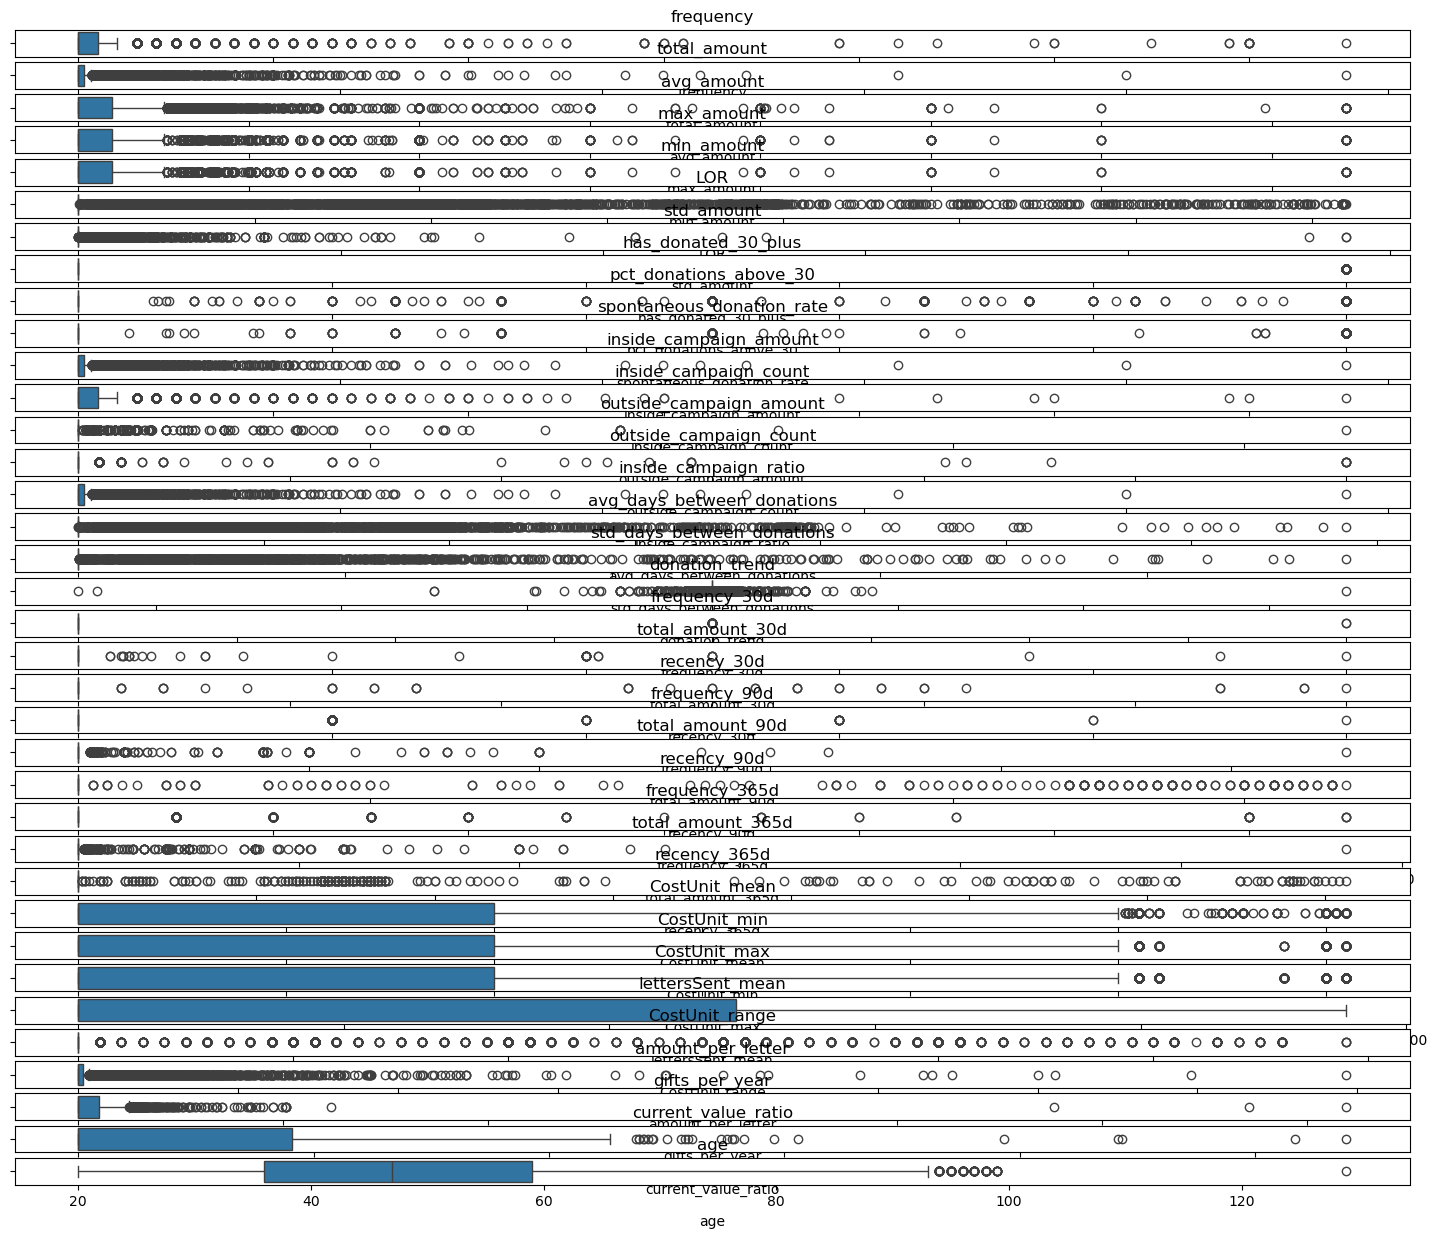

In [144]:
# Verifying outliers

fig, ax = plt.subplots(nrows=len(na_cols_train), ncols=1, figsize=(18, 15))

for i, col in enumerate(na_cols_train):
    sns.boxplot(ax=ax[i], x=basetable_train[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [145]:
# Removing the ages that are above 100
basetable_train = basetable_train[basetable_train['age'] < 100]
basetable_train['age'].max()

99

In [146]:
# We decided to keep all the other variables with their 'outliers' because they represent a very large amount (find a justification)

We removed donors whose calculated age at the campaign date exceeded 100 years. Business rationale: ages above 100 are implausible for the active donor population and likely data entry errors (e.g., mistyped birth year). Data quality: keeping these outliers could distort demographic features and model calibration. Impact: 1 record was removed from each basetable (train and validation) during the outlier filtering step.


## 2) basetable_val

### a) Cleaning columns

In [147]:
basetable_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   donorID                     25645 non-null  object        
 1   dateOfBirth                 25644 non-null  datetime64[ns]
 2   age                         25645 non-null  int64         
 3   province_Antwerp            25645 non-null  int64         
 4   province_Brussels           25645 non-null  int64         
 5   province_East Flanders      25645 non-null  int64         
 6   province_Flemish Brabant    25645 non-null  int64         
 7   province_Hainaut            25645 non-null  int64         
 8   province_Liege              25645 non-null  int64         
 9   province_Limburg            25645 non-null  int64         
 10  province_Luxembourg         25645 non-null  int64         
 11  province_Namur              25645 non-null  int64     

In [148]:
# Dropping
basetable_val = basetable_val.drop(columns=['dateOfBirth'])

In [149]:
basetable_val.columns

Index(['donorID', 'age', 'province_Antwerp', 'province_Brussels',
       'province_East Flanders', 'province_Flemish Brabant',
       'province_Hainaut', 'province_Liege', 'province_Limburg',
       'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant',
       'province_West Flanders', 'region_Flanders', 'region_Wallonia',
       'gender_M', 'language_FR', 'language_NL', 'age_group_middle_aged',
       'age_group_senior', 'age_group_youth', 'frequency', 'total_amount',
       'avg_amount', 'max_amount', 'min_amount', 'recency_days', 'std_amount',
       'has_donated_30_plus', 'pct_donations_above_30',
       'spontaneous_donation_rate', 'inside_campaign_amount',
       'inside_campaign_count', 'outside_campaign_amount',
       'outside_campaign_count', 'inside_campaign_ratio',
       'avg_days_between_donations', 'std_days_between_donations',
       'donation_trend', 'frequency_30d', 'total_amount_30d', 'recency_30d',
       'frequency_90d', 'total_amount_90d', 'recency_9

In [150]:
# Setting donorID to index
basetable_val = basetable_val.set_index('donorID') # Since we do not need it in the model but it still interesting to be reachable

### b) Missing values

In [151]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(basetable_val.isna().sum())
print('---------------------------------')
print(f'The data shows {basetable_val.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
age                               0
province_Antwerp                  0
province_Brussels                 0
province_East Flanders            0
province_Flemish Brabant          0
province_Hainaut                  0
province_Liege                    0
province_Limburg                  0
province_Luxembourg               0
province_Namur                    0
province_Walloon Brabant          0
province_West Flanders            0
region_Flanders                   0
region_Wallonia                   0
gender_M                          0
language_FR                       0
language_NL                       0
age_group_middle_aged             0
age_group_senior                  0
age_group_youth                   0
frequency                     16959
total_amount                  16959
avg_amount                    16959
max_amount                    16959
min_amount                    16959
recency_days                  16959
std

In [152]:
# Justify why we have that much missing values (business reality because some clients did not give within the 5 years window)

In [153]:
na_cols_val = basetable_val.columns

for col in na_cols_val:
    if basetable_val[col].isna().sum() == 0:
        na_cols_val = na_cols_val.drop(col)
    else:
        continue

na_cols_val

Index(['frequency', 'total_amount', 'avg_amount', 'max_amount', 'min_amount',
       'recency_days', 'std_amount', 'has_donated_30_plus',
       'pct_donations_above_30', 'spontaneous_donation_rate',
       'inside_campaign_amount', 'inside_campaign_count',
       'outside_campaign_amount', 'outside_campaign_count',
       'inside_campaign_ratio', 'avg_days_between_donations',
       'std_days_between_donations', 'donation_trend', 'frequency_30d',
       'total_amount_30d', 'recency_30d', 'frequency_90d', 'total_amount_90d',
       'recency_90d', 'frequency_365d', 'total_amount_365d', 'recency_365d',
       'LOR', 'single_gift_in_window', 'no_history', 'CostUnit_mean',
       'CostUnit_min', 'CostUnit_max', 'lettersSent_mean', 'CostUnit_range',
       'amount_per_letter', 'gifts_per_year', 'current_value_ratio'],
      dtype='object')

In [154]:
na_cols_val = na_cols_val.drop('recency_days') # recency should be inputed differently
na_cols_val = na_cols_val.drop(['no_history', 'single_gift_in_window'])

In [155]:
# Custom imputations for donation history flags
basetable_val['no_history'] = basetable_val['no_history'].fillna(1)
basetable_val['single_gift_in_window'] = basetable_val['single_gift_in_window'].fillna(0)

# Inputing by 0 for the others (they likely represent the same clients as well because they are the same number and ad interconnected)
for col in na_cols_val:
        basetable_val[col] = basetable_val[col].fillna(value=0)

In [156]:
# We have to inpute recency with another value than 0 since 0 would mislead the model
# Indeed it would mean that as soon as the donnor received the mail, he would donate
basetable_val['recency_days'] = basetable_val['recency_days'].fillna(value=99999)

In [157]:
print(f'There are {basetable_val.isna().sum().sum()} missing values in the basetable at this stage.')

There are 0 missing values in the basetable at this stage.


### c) Outliers

In [158]:
# Finding outliers (using only the numerical columns)
na_cols_val = na_cols_val.tolist()
na_cols_val.append('age') # we can see that the potential outliers are in the numerical tables which also presented NaNs
# Therefore, we only add age to these to look for outliers because age is the only other one that could present some outliers as well
na_cols_val

['frequency',
 'total_amount',
 'avg_amount',
 'max_amount',
 'min_amount',
 'std_amount',
 'has_donated_30_plus',
 'pct_donations_above_30',
 'spontaneous_donation_rate',
 'inside_campaign_amount',
 'inside_campaign_count',
 'outside_campaign_amount',
 'outside_campaign_count',
 'inside_campaign_ratio',
 'avg_days_between_donations',
 'std_days_between_donations',
 'donation_trend',
 'frequency_30d',
 'total_amount_30d',
 'recency_30d',
 'frequency_90d',
 'total_amount_90d',
 'recency_90d',
 'frequency_365d',
 'total_amount_365d',
 'recency_365d',
 'LOR',
 'CostUnit_mean',
 'CostUnit_min',
 'CostUnit_max',
 'lettersSent_mean',
 'CostUnit_range',
 'amount_per_letter',
 'gifts_per_year',
 'current_value_ratio',
 'age']

/var/folders/h2/y6w_dvsj2mv412xb0cnmyvhc0000gn/T/ipykernel_32045/2490733849.py:9: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


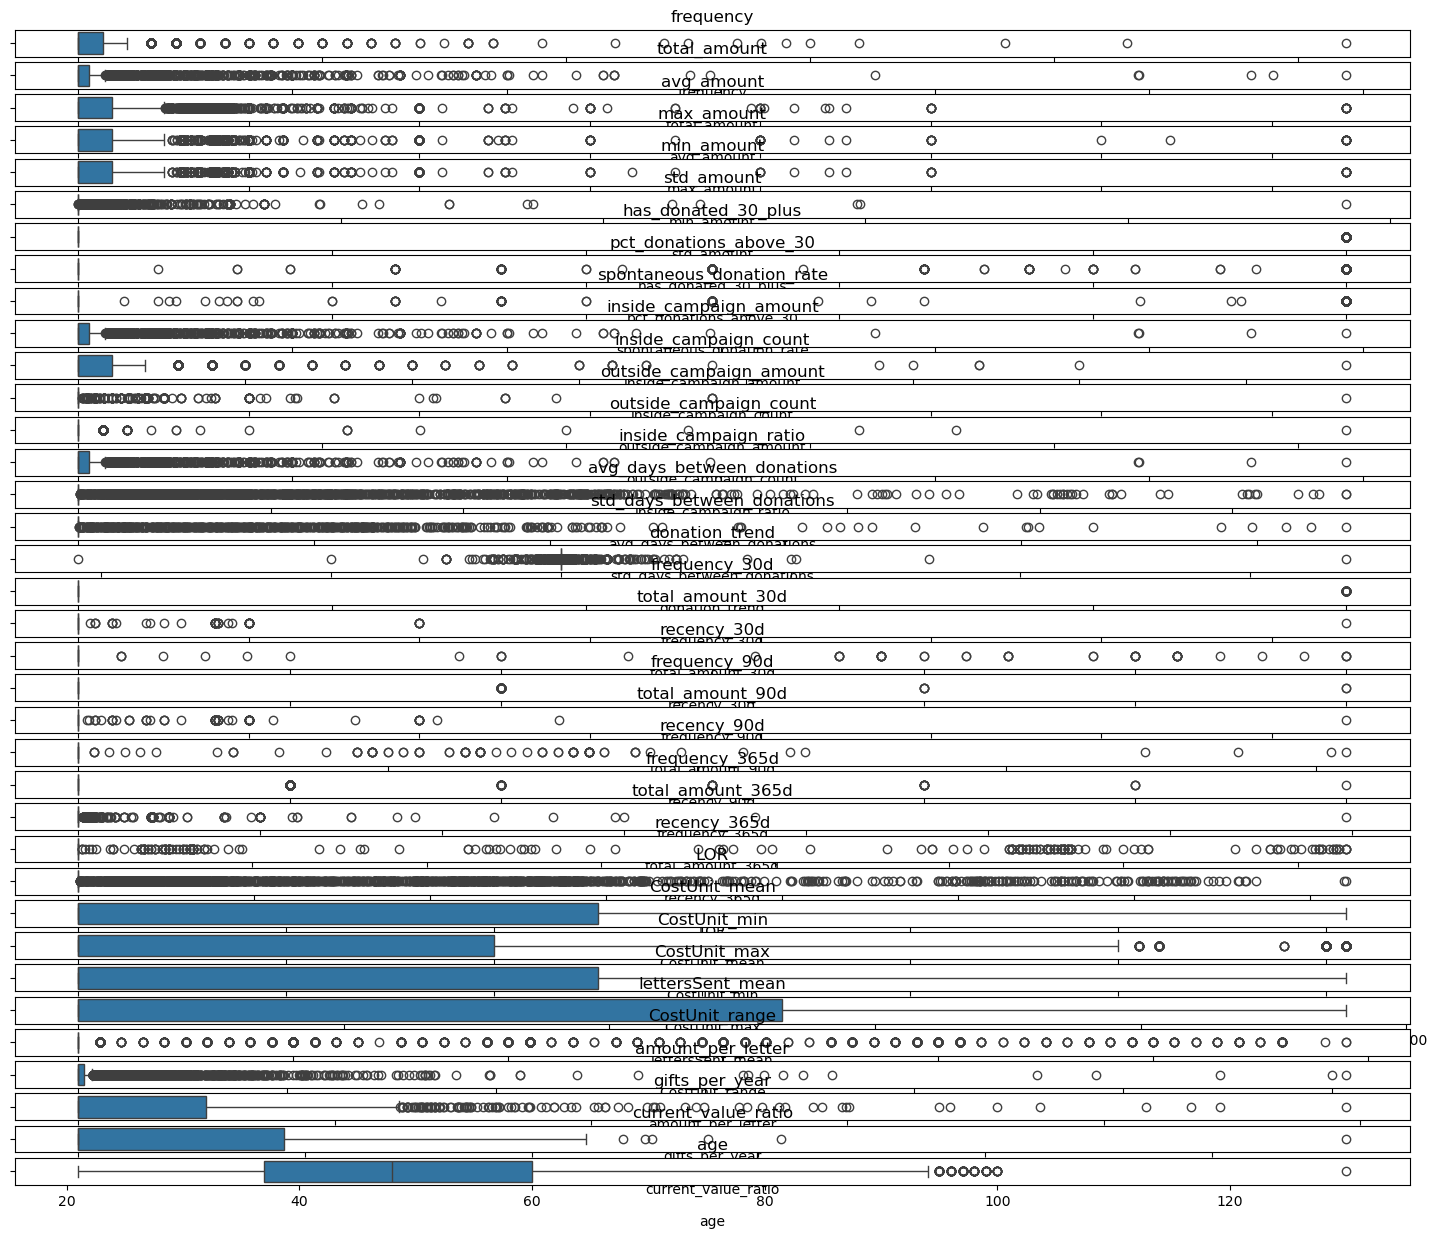

In [159]:
# Verifying outliers

fig, ax = plt.subplots(nrows=len(na_cols_val), ncols=1, figsize=(18, 15))

for i, col in enumerate(na_cols_val):
    sns.boxplot(ax=ax[i], x=basetable_val[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [160]:
# Removing the ages that are above 100
basetable_val = basetable_val[basetable_val['age'] < 100]
basetable_val['age'].max()

99

In [161]:
# We decided to keep all the other variables with their 'outliers' because they represent a very large amount (find a justification)

In [162]:
# Checking one last time the data

In [163]:
train_targets.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100004,0
3,D100008,0
4,D100009,0


In [164]:
validation_targets.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100008,0
3,D100009,0
4,D100010,0


In [165]:
basetable_train.head()

,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,...,total_amount_365d,recency_365d,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,51,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100002,66,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.000529,1.0,0.952381
D100004,66,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100008,81,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100009,86,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [166]:
basetable_val.head()

,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,...,single_gift_in_window,no_history,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,52,0,0,0,1,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100002,67,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.000529,1.0,0.952381
D100008,82,0,0,0,1,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100009,87,0,1,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100010,36,0,1,0,0,0,0,0,0,0,...,1.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.001057,1.0,0.975610


In [167]:
print(train_targets.shape)
print(basetable_train.shape)

(34888, 2)
(34887, 58)


In [168]:
print(validation_targets.shape)
print(basetable_train.shape)

(25645, 2)
(34887, 58)


In [169]:
# We notice that we have one row less in the basetable each time. This is due to the step when we filtered the basetable to remove the rows where
# the age was above 100 years old. We had only one (refer to the boxplot)
# Therefore, to adjust this situation, we have to merge the target variables into the basetable to be able to associate the right result with
# the right profile

In [170]:
basetable_train = basetable_train.merge(
    train_targets.set_index("donorID"),
    left_index=True,
    right_index=True,
    how="left"
)

basetable_train.shape

(34887, 59)

In [171]:
basetable_val = basetable_val.merge(
    validation_targets.set_index("donorID"),
    left_index=True,
    right_index=True,
    how="left"
)
basetable_val.shape

(25636, 59)

In [172]:
basetable_train.head()


,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,...,recency_365d,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio,target
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,51,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0
D100002,66,1,0,0,0,0,0,0,0,0,...,0.0,0.5,0.5,0.5,37833.0,0.0,0.000529,1.0,0.952381,0
D100004,66,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0
D100008,81,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0
D100009,86,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0


In [173]:
basetable_train.columns

Index(['age', 'province_Antwerp', 'province_Brussels',
       'province_East Flanders', 'province_Flemish Brabant',
       'province_Hainaut', 'province_Liege', 'province_Limburg',
       'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant',
       'province_West Flanders', 'region_Flanders', 'region_Wallonia',
       'gender_M', 'language_FR', 'language_NL', 'age_group_middle_aged',
       'age_group_senior', 'age_group_youth', 'frequency', 'total_amount',
       'avg_amount', 'max_amount', 'min_amount', 'recency_days', 'LOR',
       'single_gift_in_window', 'no_history', 'std_amount',
       'has_donated_30_plus', 'pct_donations_above_30',
       'spontaneous_donation_rate', 'inside_campaign_amount',
       'inside_campaign_count', 'outside_campaign_amount',
       'outside_campaign_count', 'inside_campaign_ratio',
       'avg_days_between_donations', 'std_days_between_donations',
       'donation_trend', 'frequency_30d', 'total_amount_30d', 'recency_30d',
       'freq

In [174]:
basetable_val.columns

Index(['age', 'province_Antwerp', 'province_Brussels',
       'province_East Flanders', 'province_Flemish Brabant',
       'province_Hainaut', 'province_Liege', 'province_Limburg',
       'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant',
       'province_West Flanders', 'region_Flanders', 'region_Wallonia',
       'gender_M', 'language_FR', 'language_NL', 'age_group_middle_aged',
       'age_group_senior', 'age_group_youth', 'frequency', 'total_amount',
       'avg_amount', 'max_amount', 'min_amount', 'recency_days', 'std_amount',
       'has_donated_30_plus', 'pct_donations_above_30',
       'spontaneous_donation_rate', 'inside_campaign_amount',
       'inside_campaign_count', 'outside_campaign_amount',
       'outside_campaign_count', 'inside_campaign_ratio',
       'avg_days_between_donations', 'std_days_between_donations',
       'donation_trend', 'frequency_30d', 'total_amount_30d', 'recency_30d',
       'frequency_90d', 'total_amount_90d', 'recency_90d', 'frequ

## V. Feature Selection

This section performs two-stage feature selection following the course guidelines:

1. **Univariate screening** using ROC-AUC of single-feature logistic regression.
2. **Forward stepwise selection** based on cross-validated AUC improvement.

Targets are merged after outlier removal to ensure alignment.  
The same selection process is applied consistently to training and validation data.


In [175]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


## Attach targets & prepare X/y

In [176]:
# ============================================
# PREPARE DATA FOR MODELING
# ============================================

# Target column
target_col = 'target'

# All columns except target are features
feature_cols = [col for col in basetable_train.columns if col != target_col]

# Separate X and y (donorID is the index, so it won't be in columns)
X_train = basetable_train[feature_cols].copy()
y_train = basetable_train[target_col].copy()

X_val = basetable_val[feature_cols].copy()
y_val = basetable_val[target_col].copy()

print("="*60)
print("DATA PREPARED FOR MODELING")
print("="*60)
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nTarget distribution - Train:")
print(y_train.value_counts())
print(f"Response rate: {y_train.mean():.2%}")
print(f"\nTarget distribution - Validation:")
print(y_val.value_counts())
print(f"Response rate: {y_val.mean():.2%}")

DATA PREPARED FOR MODELING
X_train shape: (34887, 58)
X_val shape: (25636, 58)
Number of features: 58

Target distribution - Train:
target
0    34122
1      765
Name: count, dtype: int64
Response rate: 2.19%

Target distribution - Validation:
target
0    25455
1      181
Name: count, dtype: int64
Response rate: 0.71%


In [177]:
# ============================================
# FINAL DATA QUALITY CHECK
# ============================================

print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_val:", X_val.isnull().sum().sum())

print("\nInfinite values in X_train:", np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum())
print("Infinite values in X_val:", np.isinf(X_val.select_dtypes(include=[np.number])).sum().sum())

# Fill any remaining issues
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

# Replace infinite values
X_train = X_train.replace([np.inf, -np.inf], 0)
X_val = X_val.replace([np.inf, -np.inf], 0)

print("\n✓ Data ready for modeling")
print(f"\nFeature preview:")
print(X_train.head())

Missing values in X_train: 0
Missing values in X_val: 0

Infinite values in X_train: 0
Infinite values in X_val: 0

✓ Data ready for modeling

Feature preview:
         age  province_Antwerp  province_Brussels  province_East Flanders  \
donorID                                                                     
D100001   51                 0                  0                       0   
D100002   66                 1                  0                       0   
D100004   66                 0                  1                       0   
D100008   81                 0                  0                       0   
D100009   86                 0                  1                       0   

         province_Flemish Brabant  province_Hainaut  province_Liege  \
donorID                                                               
D100001                         1                 0               0   
D100002                         0                 0               0   
D100004         

In [178]:
# ============================================
# UNIVARIATE FEATURE SELECTION
# ============================================

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

univariate_scores = []

print("Calculating univariate AUC scores...")
print("This may take a minute...")

for i, feature in enumerate(feature_cols, 1):
    try:
        # Train simple logistic regression with one feature
        model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
        
        # Reshape for sklearn (needs 2D array)
        X_single_train = X_train[[feature]]
        X_single_val = X_val[[feature]]
        
        # Fit model
        model.fit(X_single_train, y_train)
        
        # Predict on validation
        y_pred_proba = model.predict_proba(X_single_val)[:, 1]
        
        # Calculate AUC
        auc = roc_auc_score(y_val, y_pred_proba)
        
        univariate_scores.append({
            'feature': feature,
            'auc': auc
        })
        
        if i % 10 == 0:
            print(f"Processed {i}/{len(feature_cols)} features...")
        
    except Exception as e:
        print(f"Error with feature {feature}: {e}")
        continue

# Create dataframe
univariate_df = pd.DataFrame(univariate_scores).sort_values('auc', ascending=False)

print(f"\n✓ Completed univariate analysis for {len(univariate_df)} features")

Calculating univariate AUC scores...
This may take a minute...
Processed 10/58 features...
Processed 20/58 features...
Processed 30/58 features...
Processed 40/58 features...
Processed 50/58 features...

✓ Completed univariate analysis for 58 features


TOP 20 FEATURES - UNIVARIATE SELECTION
               feature      auc
              gender_M 0.589002
            max_amount 0.580968
            min_amount 0.580463
            avg_amount 0.579687
pct_donations_above_30 0.577787
   has_donated_30_plus 0.577453
          total_amount 0.575080
   current_value_ratio 0.574934
inside_campaign_amount 0.561225
 inside_campaign_ratio 0.558863
          recency_days 0.555604
            no_history 0.549228
             frequency 0.548687
 single_gift_in_window 0.539214
          CostUnit_max 0.538133
          CostUnit_min 0.537787
         CostUnit_mean 0.537710
      lettersSent_mean 0.537179
 inside_campaign_count 0.536832
        gifts_per_year 0.535541

🏆 Best single feature: gender_M
   AUC: 0.5890


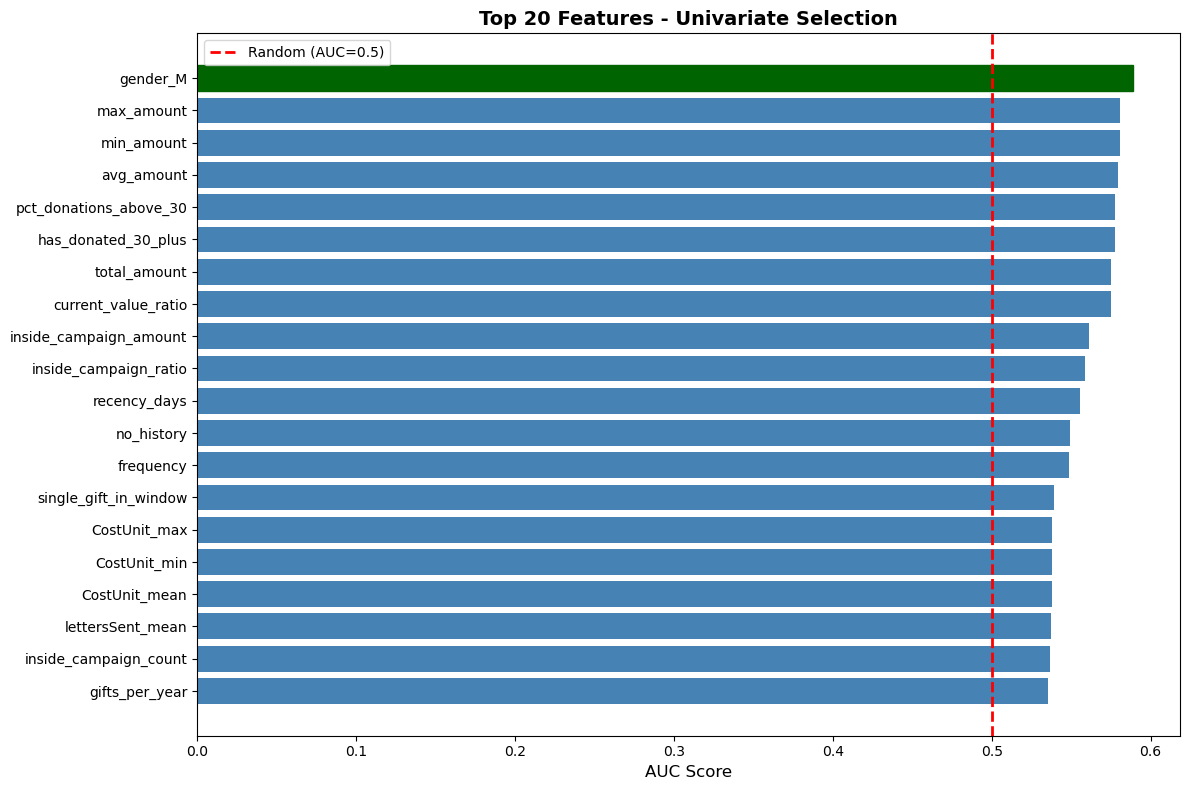

In [179]:
# ============================================
# VISUALIZE UNIVARIATE RESULTS - TOP 20
# ============================================

print("="*60)
print("TOP 20 FEATURES - UNIVARIATE SELECTION")
print("="*60)
print(univariate_df.head(20).to_string(index=False))

print(f"\n🏆 Best single feature: {univariate_df.iloc[0]['feature']}")
print(f"   AUC: {univariate_df.iloc[0]['auc']:.4f}")

# Plot top 20
plt.figure(figsize=(12, 8))
top_20 = univariate_df.head(20)
bars = plt.barh(range(len(top_20)), top_20['auc'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('AUC Score', fontsize=12)
plt.title('Top 20 Features - Univariate Selection', fontsize=14, fontweight='bold')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random (AUC=0.5)')

# Color the best bar differently
bars[0].set_color('darkgreen')

plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

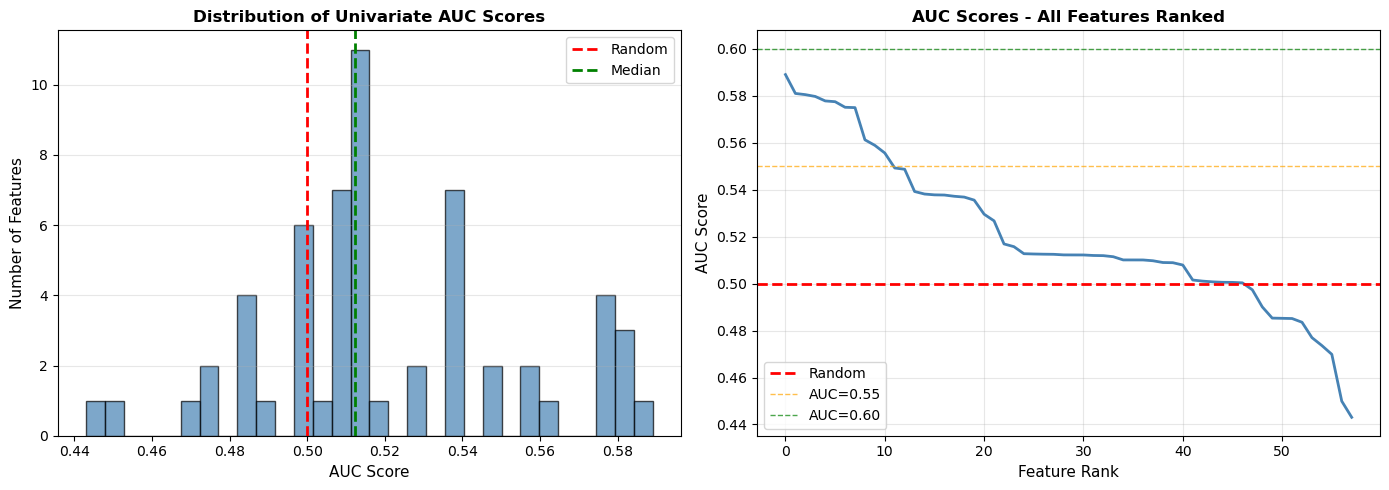

UNIVARIATE SELECTION STATISTICS
Total features analyzed: 58
Features with AUC > 0.50: 47
Features with AUC > 0.55: 11
Features with AUC > 0.60: 0
Features with AUC > 0.65: 0

Median AUC: 0.5122
Mean AUC: 0.5206


In [180]:
# ============================================
# DISTRIBUTION OF UNIVARIATE AUC SCORES
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram
axes[0].hist(univariate_df['auc'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random')
axes[0].axvline(x=univariate_df['auc'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('AUC Score', fontsize=11)
axes[0].set_ylabel('Number of Features', fontsize=11)
axes[0].set_title('Distribution of Univariate AUC Scores', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Ranked features
axes[1].plot(range(len(univariate_df)), univariate_df['auc'].values, linewidth=2, color='steelblue')
axes[1].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Random')
axes[1].axhline(y=0.55, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='AUC=0.55')
axes[1].axhline(y=0.60, color='green', linestyle='--', linewidth=1, alpha=0.7, label='AUC=0.60')
axes[1].set_xlabel('Feature Rank', fontsize=11)
axes[1].set_ylabel('AUC Score', fontsize=11)
axes[1].set_title('AUC Scores - All Features Ranked', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)
print("UNIVARIATE SELECTION STATISTICS")
print("="*60)
print(f"Total features analyzed: {len(univariate_df)}")
print(f"Features with AUC > 0.50: {(univariate_df['auc'] > 0.50).sum()}")
print(f"Features with AUC > 0.55: {(univariate_df['auc'] > 0.55).sum()}")
print(f"Features with AUC > 0.60: {(univariate_df['auc'] > 0.60).sum()}")
print(f"Features with AUC > 0.65: {(univariate_df['auc'] > 0.65).sum()}")
print(f"\nMedian AUC: {univariate_df['auc'].median():.4f}")
print(f"Mean AUC: {univariate_df['auc'].mean():.4f}")

In [181]:
# ============================================
# SELECT FEATURES - UNIVARIATE
# ============================================

# Set threshold (adjust based on your distribution)
auc_threshold = 0.53

selected_univariate = univariate_df[univariate_df['auc'] > auc_threshold]['feature'].tolist()

print("="*60)
print(f"UNIVARIATE SELECTION (AUC > {auc_threshold})")
print("="*60)
print(f"Selected features: {len(selected_univariate)}")
print(f"\nSelected features list:")
for i, feat in enumerate(selected_univariate, 1):
    auc = univariate_df[univariate_df['feature'] == feat]['auc'].values[0]
    print(f"{i:2d}. {feat:40s} AUC: {auc:.4f}")

UNIVARIATE SELECTION (AUC > 0.53)
Selected features: 20

Selected features list:
 1. gender_M                                 AUC: 0.5890
 2. max_amount                               AUC: 0.5810
 3. min_amount                               AUC: 0.5805
 4. avg_amount                               AUC: 0.5797
 5. pct_donations_above_30                   AUC: 0.5778
 6. has_donated_30_plus                      AUC: 0.5775
 7. total_amount                             AUC: 0.5751
 8. current_value_ratio                      AUC: 0.5749
 9. inside_campaign_amount                   AUC: 0.5612
10. inside_campaign_ratio                    AUC: 0.5589
11. recency_days                             AUC: 0.5556
12. no_history                               AUC: 0.5492
13. frequency                                AUC: 0.5487
14. single_gift_in_window                    AUC: 0.5392
15. CostUnit_max                             AUC: 0.5381
16. CostUnit_min                             AUC: 0.5378
17. Cos

In [182]:
# ============================================
# STEPWISE FORWARD SELECTION
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def stepwise_forward_selection(X_train, y_train, X_val, y_val, 
                               max_features=20, min_improvement=0.001):
    """
    Perform stepwise forward feature selection
    """
    selected_features = []
    remaining_features = list(X_train.columns)
    
    results = []
    
    print("Starting stepwise forward selection...")
    print("="*60)
    
    for step in range(1, max_features + 1):
        best_auc = 0
        best_feature = None
        
        print(f"\nStep {step}: Testing {len(remaining_features)} remaining features...")
        
        # Try adding each remaining feature
        for feature in remaining_features:
            # Current feature set
            current_features = selected_features + [feature]
            
            # Train model
            model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
            model.fit(X_train[current_features], y_train)
            
            # Predict and evaluate
            y_pred_proba = model.predict_proba(X_val[current_features])[:, 1]
            auc = roc_auc_score(y_val, y_pred_proba)
            
            # Track best
            if auc > best_auc:
                best_auc = auc
                best_feature = feature
        
        # Check if improvement is significant
        if step > 1 and (best_auc - results[-1]['val_auc']) < min_improvement:
            print(f"\n⚠️ Stopping at {step-1} features (improvement < {min_improvement})")
            break
        
        # Add best feature
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        
        # Train final model with selected features
        model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
        model.fit(X_train[selected_features], y_train)
        
        # Calculate train and val AUC
        train_pred = model.predict_proba(X_train[selected_features])[:, 1]
        val_pred = model.predict_proba(X_val[selected_features])[:, 1]
        
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)
        
        results.append({
            'step': step,
            'feature_added': best_feature,
            'train_auc': train_auc,
            'val_auc': val_auc,
            'improvement': val_auc - results[-1]['val_auc'] if step > 1 else val_auc - 0.5,
            'features': selected_features.copy()
        })
        
        print(f"✓ Step {step:2d}: Added '{best_feature}'")
        print(f"   Val AUC: {val_auc:.4f} | Train AUC: {train_auc:.4f} | Improvement: {results[-1]['improvement']:+.4f}")
    
    return pd.DataFrame(results), selected_features

# Run stepwise selection
print("Starting stepwise forward selection (this may take several minutes)...\n")
stepwise_results, selected_stepwise = stepwise_forward_selection(
    X_train, y_train, X_val, y_val, 
    max_features=20,
    min_improvement=0.0005  # Stop if improvement < 0.05%
)

print("\n" + "="*60)
print("✓ STEPWISE SELECTION COMPLETE")
print("="*60)
print(f"Total features selected: {len(selected_stepwise)}")

Starting stepwise forward selection (this may take several minutes)...

Starting stepwise forward selection...

Step 1: Testing 58 remaining features...
✓ Step  1: Added 'gender_M'
   Val AUC: 0.5890 | Train AUC: 0.6459 | Improvement: +0.0890

Step 2: Testing 57 remaining features...
✓ Step  2: Added 'max_amount'
   Val AUC: 0.6306 | Train AUC: 0.6733 | Improvement: +0.0416

Step 3: Testing 56 remaining features...
✓ Step  3: Added 'age_group_middle_aged'
   Val AUC: 0.6443 | Train AUC: 0.6775 | Improvement: +0.0137

Step 4: Testing 55 remaining features...
✓ Step  4: Added 'language_NL'
   Val AUC: 0.6469 | Train AUC: 0.6822 | Improvement: +0.0026

Step 5: Testing 54 remaining features...
✓ Step  5: Added 'total_amount_90d'
   Val AUC: 0.6503 | Train AUC: 0.6822 | Improvement: +0.0034

Step 6: Testing 53 remaining features...
✓ Step  6: Added 'recency_30d'
   Val AUC: 0.6524 | Train AUC: 0.6823 | Improvement: +0.0021

Step 7: Testing 52 remaining features...


/Users/mac/anaconda3/envs/py/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✓ Step  7: Added 'province_Walloon Brabant'
   Val AUC: 0.6537 | Train AUC: 0.6823 | Improvement: +0.0013

Step 8: Testing 51 remaining features...
✓ Step  8: Added 'province_Brussels'
   Val AUC: 0.6578 | Train AUC: 0.6830 | Improvement: +0.0041

Step 9: Testing 50 remaining features...


/Users/mac/anaconda3/envs/py/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



⚠️ Stopping at 8 features (improvement < 0.0005)

✓ STEPWISE SELECTION COMPLETE
Total features selected: 8


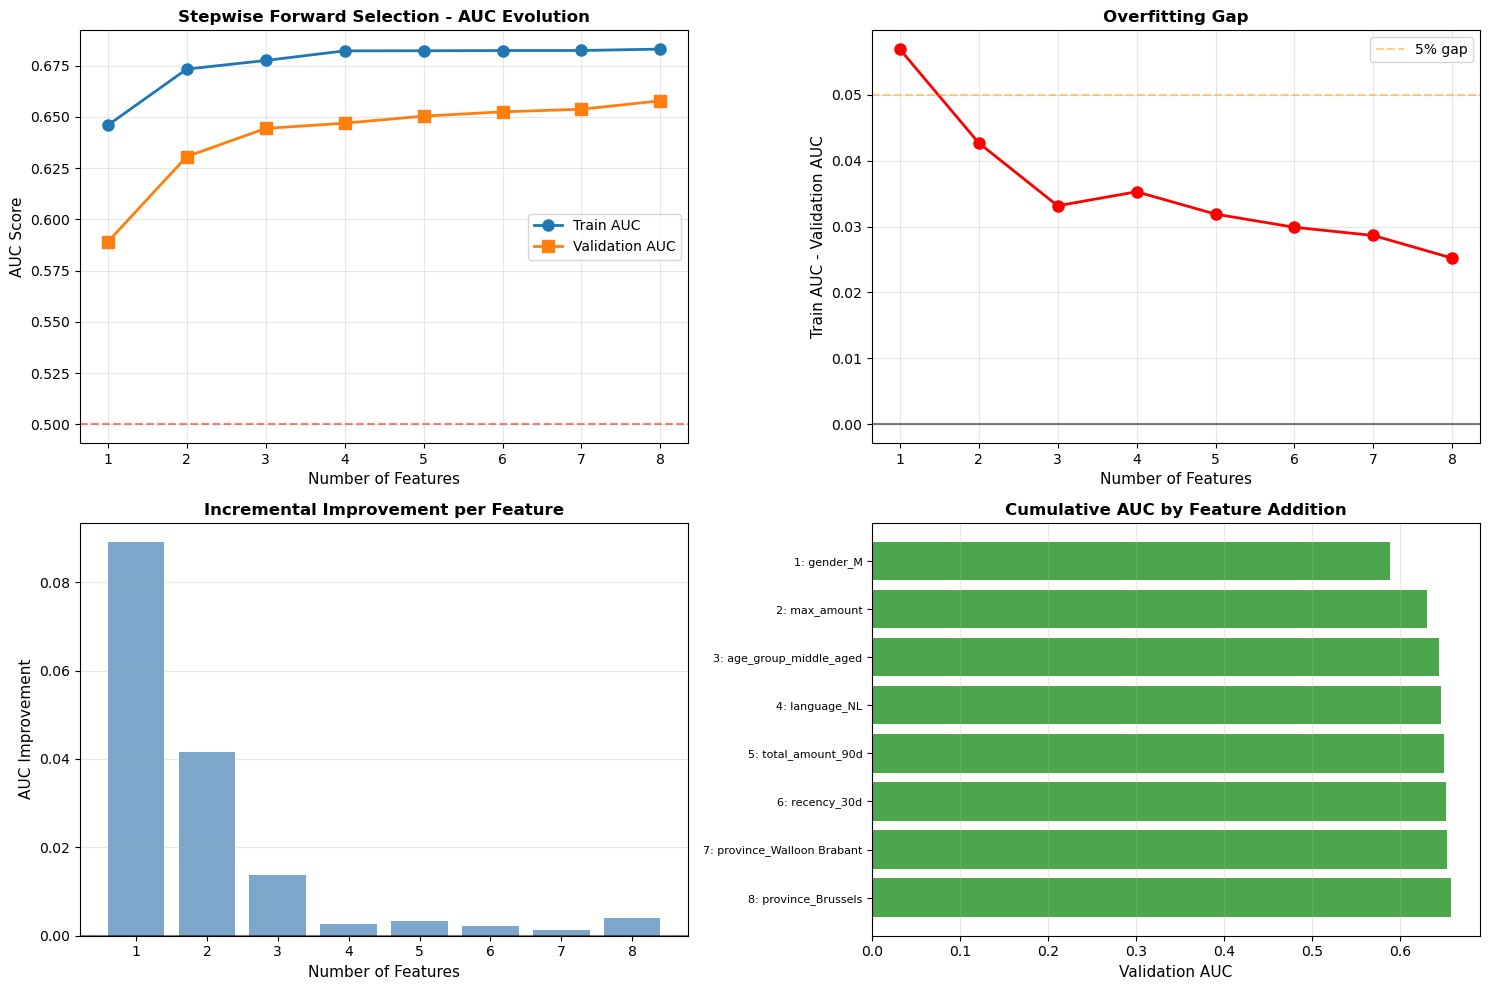

OPTIMAL MODEL FROM STEPWISE SELECTION
Optimal number of features: 8
Validation AUC: 0.6578
Train AUC: 0.6830
Overfitting gap: 0.0252

✓ Optimal feature set:
 1. gender_M
 2. max_amount
 3. age_group_middle_aged
 4. language_NL
 5. total_amount_90d
 6. recency_30d
 7. province_Walloon Brabant
 8. province_Brussels


In [183]:
# ============================================
# VISUALIZE STEPWISE RESULTS
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: AUC vs Number of Features
axes[0, 0].plot(stepwise_results['step'], stepwise_results['train_auc'], 
                marker='o', label='Train AUC', linewidth=2, markersize=8)
axes[0, 0].plot(stepwise_results['step'], stepwise_results['val_auc'], 
                marker='s', label='Validation AUC', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Features', fontsize=11)
axes[0, 0].set_ylabel('AUC Score', fontsize=11)
axes[0, 0].set_title('Stepwise Forward Selection - AUC Evolution', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)

# Plot 2: Overfitting Gap
overfitting_gap = stepwise_results['train_auc'] - stepwise_results['val_auc']
axes[0, 1].plot(stepwise_results['step'], overfitting_gap, 
                marker='o', color='red', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Features', fontsize=11)
axes[0, 1].set_ylabel('Train AUC - Validation AUC', fontsize=11)
axes[0, 1].set_title('Overfitting Gap', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[0, 1].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='5% gap')
axes[0, 1].legend(fontsize=10)

# Plot 3: Incremental Improvement
axes[1, 0].bar(stepwise_results['step'], stepwise_results['improvement'], 
               color='steelblue', alpha=0.7)
axes[1, 0].set_xlabel('Number of Features', fontsize=11)
axes[1, 0].set_ylabel('AUC Improvement', fontsize=11)
axes[1, 0].set_title('Incremental Improvement per Feature', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Plot 4: Feature importance (validation AUC contribution)
axes[1, 1].barh(range(len(stepwise_results)), stepwise_results['val_auc'], color='green', alpha=0.7)
axes[1, 1].set_yticks(range(len(stepwise_results)))
axes[1, 1].set_yticklabels([f"{r['step']}: {r['feature_added'][:25]}" for _, r in stepwise_results.iterrows()], 
                           fontsize=8)
axes[1, 1].set_xlabel('Validation AUC', fontsize=11)
axes[1, 1].set_title('Cumulative AUC by Feature Addition', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# Find optimal number of features
best_idx = stepwise_results['val_auc'].idxmax()
optimal_features = stepwise_results.loc[best_idx, 'step']
optimal_auc = stepwise_results.loc[best_idx, 'val_auc']

print("="*60)
print("OPTIMAL MODEL FROM STEPWISE SELECTION")
print("="*60)
print(f"Optimal number of features: {optimal_features}")
print(f"Validation AUC: {optimal_auc:.4f}")
print(f"Train AUC: {stepwise_results.loc[best_idx, 'train_auc']:.4f}")
print(f"Overfitting gap: {stepwise_results.loc[best_idx, 'train_auc'] - optimal_auc:.4f}")
print(f"\n✓ Optimal feature set:")
for i, feat in enumerate(stepwise_results.loc[best_idx, 'features'], 1):
    print(f"{i:2d}. {feat}")

In [184]:
# ============================================
# STEPWISE RESULTS TABLE
# ============================================

print("="*60)
print("STEPWISE SELECTION - DETAILED RESULTS")
print("="*60)
display_cols = ['step', 'feature_added', 'train_auc', 'val_auc', 'improvement']
print(stepwise_results[display_cols].to_string(index=False))

# Save final selected features
final_selected_features = stepwise_results.loc[best_idx, 'features']
print(f"\n✓ Final selected features: {len(final_selected_features)}")

STEPWISE SELECTION - DETAILED RESULTS
 step            feature_added  train_auc  val_auc  improvement
    1                 gender_M   0.645889 0.589002     0.089002
    2               max_amount   0.673280 0.630609     0.041607
    3    age_group_middle_aged   0.677484 0.644343     0.013734
    4              language_NL   0.682170 0.646903     0.002560
    5         total_amount_90d   0.682210 0.650333     0.003430
    6              recency_30d   0.682325 0.652441     0.002108
    7 province_Walloon Brabant   0.682346 0.653707     0.001266
    8        province_Brussels   0.683027 0.657828     0.004121

✓ Final selected features: 8


# Modeling

In [185]:
# ============================================
# IMPORT MODEL LIBRARIES
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [186]:
# ============================================
# CHOOSE FEATURE SET FOR MODELING
# ============================================

# Option 1: Use stepwise selected features (RECOMMENDED)
features_to_use = final_selected_features

# Option 2: Use all features (uncomment to test)
# features_to_use = feature_cols

# Option 3: Use univariate selected features (uncomment to test)
# features_to_use = selected_univariate

print("="*60)
print("FEATURE SET SELECTION")
print("="*60)
print(f"Using {len(features_to_use)} features for modeling")
print(f"\nFeatures:")
for i, feat in enumerate(features_to_use, 1):
    print(f"{i:2d}. {feat}")

X_train_model = X_train[features_to_use].copy()
X_val_model = X_val[features_to_use].copy()

print(f"\n✓ Model data prepared")
print(f"   X_train_model: {X_train_model.shape}")
print(f"   X_val_model: {X_val_model.shape}")

FEATURE SET SELECTION
Using 8 features for modeling

Features:
 1. gender_M
 2. max_amount
 3. age_group_middle_aged
 4. language_NL
 5. total_amount_90d
 6. recency_30d
 7. province_Walloon Brabant
 8. province_Brussels

✓ Model data prepared
   X_train_model: (34887, 8)
   X_val_model: (25636, 8)


In [187]:
# ============================================
# MODEL 1: LOGISTIC REGRESSION
# ============================================

print("="*60)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*60)

lr_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0, solver='lbfgs', class_weight='balanced')
lr_model.fit(X_train_model, y_train)

# Predictions
lr_train_pred = lr_model.predict_proba(X_train_model)[:, 1]
lr_val_pred = lr_model.predict_proba(X_val_model)[:, 1]

# AUC
lr_train_auc = roc_auc_score(y_train, lr_train_pred)
lr_val_auc = roc_auc_score(y_val, lr_val_pred)

print(f"Train AUC: {lr_train_auc:.4f}")
print(f"Validation AUC: {lr_val_auc:.4f}")
print(f"Overfitting gap: {(lr_train_auc - lr_val_auc):.4f}")

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': features_to_use,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\n📊 Top 10 most important features (by |coefficient|):")
print(feature_importance_lr.head(10).to_string(index=False))

print("\n✓ Logistic Regression trained successfully")

MODEL 1: LOGISTIC REGRESSION
Train AUC: 0.6859
Validation AUC: 0.6541
Overfitting gap: 0.0318

📊 Top 10 most important features (by |coefficient|):
                 feature  coefficient
province_Walloon Brabant    -1.576540
                gender_M    -1.216754
             language_NL     0.246708
       province_Brussels    -0.147448
   age_group_middle_aged    -0.143631
             recency_30d     0.036213
              max_amount     0.013782
        total_amount_90d     0.010824

✓ Logistic Regression trained successfully


In [188]:
# ============================================
# MODEL 2: DECISION TREE
# ============================================

print("="*60)
print("MODEL 2: DECISION TREE")
print("="*60)

dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42
)
dt_model.fit(X_train_model, y_train)

# Predictions
dt_train_pred = dt_model.predict_proba(X_train_model)[:, 1]
dt_val_pred = dt_model.predict_proba(X_val_model)[:, 1]

# AUC
dt_train_auc = roc_auc_score(y_train, dt_train_pred)
dt_val_auc = roc_auc_score(y_val, dt_val_pred)

print(f"Train AUC: {dt_train_auc:.4f}")
print(f"Validation AUC: {dt_val_auc:.4f}")
print(f"Overfitting gap: {(dt_train_auc - dt_val_auc):.4f}")

# Feature importance
feature_importance_dt = pd.DataFrame({
    'feature': features_to_use,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 most important features:")
print(feature_importance_dt.head(10).to_string(index=False))

print("\n✓ Decision Tree trained successfully")

MODEL 2: DECISION TREE
Train AUC: 0.7356
Validation AUC: 0.5223
Overfitting gap: 0.2134

📊 Top 10 most important features:
                 feature  importance
              max_amount    0.880041
                gender_M    0.113652
   age_group_middle_aged    0.005888
             language_NL    0.000419
        total_amount_90d    0.000000
             recency_30d    0.000000
province_Walloon Brabant    0.000000
       province_Brussels    0.000000

✓ Decision Tree trained successfully


In [189]:
# ============================================
# MODEL 3: RANDOM FOREST
# ============================================

print("="*60)
print("MODEL 3: RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=25,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest (this may take a minute)...")
rf_model.fit(X_train_model, y_train)

# Predictions
rf_train_pred = rf_model.predict_proba(X_train_model)[:, 1]
rf_val_pred = rf_model.predict_proba(X_val_model)[:, 1]

# AUC
rf_train_auc = roc_auc_score(y_train, rf_train_pred)
rf_val_auc = roc_auc_score(y_val, rf_val_pred)

print(f"Train AUC: {rf_train_auc:.4f}")
print(f"Validation AUC: {rf_val_auc:.4f}")
print(f"Overfitting gap: {(rf_train_auc - rf_val_auc):.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': features_to_use,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 most important features:")
print(feature_importance_rf.head(10).to_string(index=False))

print("\n✓ Random Forest trained successfully")

MODEL 3: RANDOM FOREST
Training Random Forest (this may take a minute)...
Train AUC: 0.7639
Validation AUC: 0.6332
Overfitting gap: 0.1307

📊 Top 10 most important features:
                 feature  importance
              max_amount    0.729827
                gender_M    0.201161
        total_amount_90d    0.032812
   age_group_middle_aged    0.016567
             language_NL    0.008026
       province_Brussels    0.005420
province_Walloon Brabant    0.005156
             recency_30d    0.001031

✓ Random Forest trained successfully


In [190]:
# ============================================
# MODEL 4: GRADIENT BOOSTING
# ============================================

print("="*60)
print("MODEL 4: GRADIENT BOOSTING")
print("="*60)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=25,
    random_state=42
)

print("Training Gradient Boosting (this may take a minute)...")
gb_model.fit(X_train_model, y_train)

# Predictions
gb_train_pred = gb_model.predict_proba(X_train_model)[:, 1]
gb_val_pred = gb_model.predict_proba(X_val_model)[:, 1]

# AUC
gb_train_auc = roc_auc_score(y_train, gb_train_pred)
gb_val_auc = roc_auc_score(y_val, gb_val_pred)

print(f"Train AUC: {gb_train_auc:.4f}")
print(f"Validation AUC: {gb_val_auc:.4f}")
print(f"Overfitting gap: {(gb_train_auc - gb_val_auc):.4f}")

# Feature importance
feature_importance_gb = pd.DataFrame({
    'feature': features_to_use,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 most important features:")
print(feature_importance_gb.head(10).to_string(index=False))

print("\n✓ Gradient Boosting trained successfully")

MODEL 4: GRADIENT BOOSTING
Training Gradient Boosting (this may take a minute)...
Train AUC: 0.8142
Validation AUC: 0.5949
Overfitting gap: 0.2193

📊 Top 10 most important features:
                 feature  importance
              max_amount    0.878597
                gender_M    0.084350
   age_group_middle_aged    0.014291
        total_amount_90d    0.013874
             language_NL    0.003363
       province_Brussels    0.003190
province_Walloon Brabant    0.002308
             recency_30d    0.000026

✓ Gradient Boosting trained successfully


In [191]:
# ============================================
# MODEL 5: SVM
# ============================================
print("="*60)
print("MODEL 5: SUPPORT VECTOR MACHINE")
print("="*60)
from sklearn.svm import SVC
svm_model = SVC(
    C=1.0,
    kernel='rbf',
    probability=True,
    random_state=42
)
print("Training Support Vector Machine (this may take a minute)...")
svm_model.fit(X_train_model, y_train)
# Predictions
svm_train_pred = svm_model.predict_proba(X_train_model)[:, 1]
svm_val_pred = svm_model.predict_proba(X_val_model)[:, 1]
# AUC
svm_train_auc = roc_auc_score(y_train, svm_train_pred)
svm_val_auc = roc_auc_score(y_val, svm_val_pred)
print(f"Train AUC: {svm_train_auc:.4f}")
print(f"Validation AUC: {svm_val_auc:.4f}")
print(f"Overfitting gap: {(svm_train_auc - svm_val_auc):.4f}")
print("\n✓ Support Vector Machine trained successfully")

MODEL 5: SUPPORT VECTOR MACHINE
Training Support Vector Machine (this may take a minute)...
Train AUC: 0.5014
Validation AUC: 0.4678
Overfitting gap: 0.0336

✓ Support Vector Machine trained successfully


In [192]:
# ============================================
# MODEL 6: xgboost
# ============================================
print("="*60)
print("MODEL 6: XGBoost")
print("="*60)
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=3,               # keep shallow!
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='auc',
    early_stopping_rounds=50,
    random_state=42
)
print("Training XGBoost (this may take a minute)...")

xgb_model.fit(X_train_model, y_train,
          eval_set=[(X_val_model, y_val)],
          verbose=50)

# Predictions
xgb_train_pred = xgb_model.predict_proba(X_train_model)[:, 1]
xgb_val_pred = xgb_model.predict_proba(X_val_model)[:, 1]
# AUC
xgb_train_auc = roc_auc_score(y_train, svm_train_pred)
xgb_val_auc = roc_auc_score(y_val, svm_val_pred)
print(f"Train AUC: {xgb_train_auc:.4f}")
print(f"Validation AUC: {xgb_val_auc:.4f}")
print(f"Overfitting gap: {(xgb_train_auc - xgb_val_auc):.4f}")
print("\n✓ XGBoost trained successfully")


MODEL 6: XGBoost
Training XGBoost (this may take a minute)...
[0]	validation_0-auc:0.45708
[50]	validation_0-auc:0.62329
[61]	validation_0-auc:0.61656
Train AUC: 0.5014
Validation AUC: 0.4678
Overfitting gap: 0.0336

✓ XGBoost trained successfully


In [193]:
# ============================================
# MODEL COMPARISON
# ============================================

# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', "Support Vector Machine"],
    'Train AUC': [lr_train_auc, dt_train_auc, rf_train_auc, gb_train_auc, svm_train_auc],
    'Validation AUC': [lr_val_auc, dt_val_auc, rf_val_auc, gb_val_auc, svm_val_auc]
})

model_comparison['Overfitting Gap'] = model_comparison['Train AUC'] - model_comparison['Validation AUC']
model_comparison = model_comparison.sort_values('Validation AUC', ascending=False)

print("="*60)
print("MODEL COMPARISON")
print("="*60)
print(model_comparison.to_string(index=False))

# Find best model
best_model_idx = model_comparison['Validation AUC'].idxmax()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
best_val_auc = model_comparison.loc[best_model_idx, 'Validation AUC']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Validation AUC: {best_val_auc:.4f}")
print(f"   Train AUC: {model_comparison.loc[best_model_idx, 'Train AUC']:.4f}")
print(f"   Overfitting Gap: {model_comparison.loc[best_model_idx, 'Overfitting Gap']:.4f}")

MODEL COMPARISON
                 Model  Train AUC  Validation AUC  Overfitting Gap
   Logistic Regression   0.685859        0.654078         0.031780
         Random Forest   0.763902        0.633172         0.130731
     Gradient Boosting   0.814210        0.594921         0.219288
         Decision Tree   0.735624        0.522273         0.213351
Support Vector Machine   0.501400        0.467795         0.033606

🏆 BEST MODEL: Logistic Regression
   Validation AUC: 0.6541
   Train AUC: 0.6859
   Overfitting Gap: 0.0318


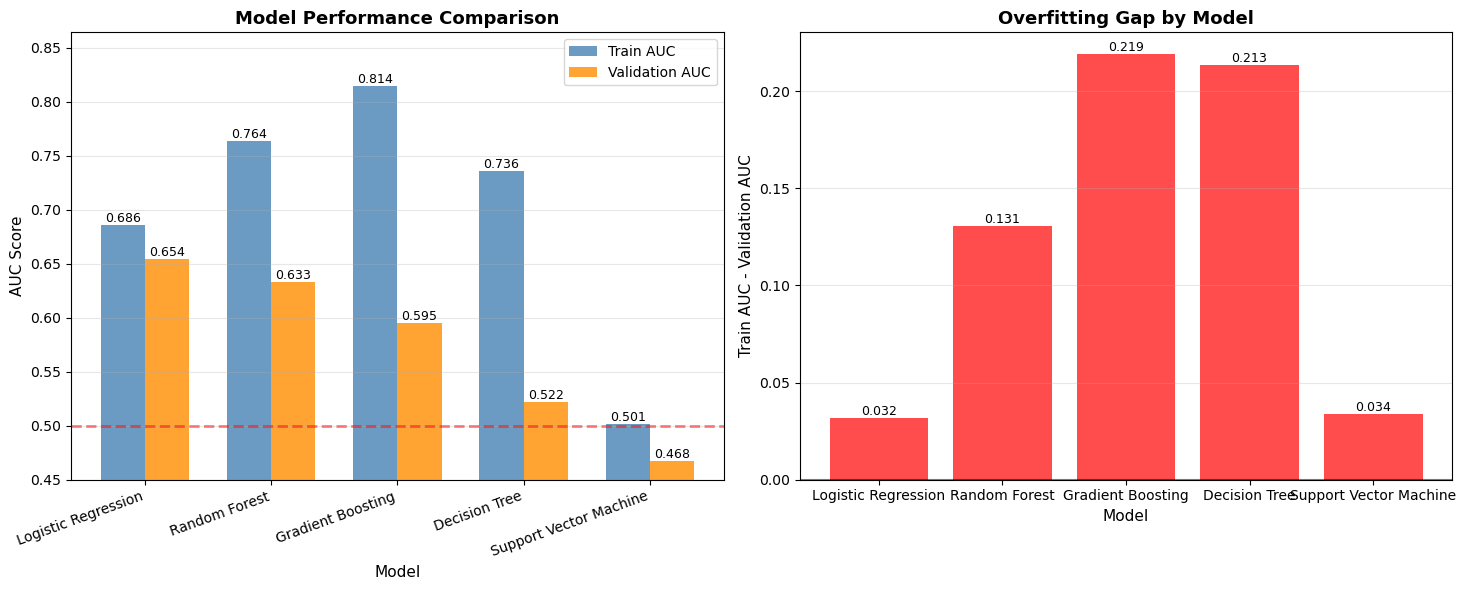

In [194]:
# ============================================
# VISUALIZE MODEL COMPARISON
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: AUC Comparison
x = np.arange(len(model_comparison))
width = 0.35

bars1 = axes[0].bar(x - width/2, model_comparison['Train AUC'], width, 
                    label='Train AUC', alpha=0.8, color='steelblue')
bars2 = axes[0].bar(x + width/2, model_comparison['Validation AUC'], width, 
                    label='Validation AUC', alpha=0.8, color='darkorange')

axes[0].set_xlabel('Model', fontsize=11)
axes[0].set_ylabel('AUC Score', fontsize=11)
axes[0].set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_comparison['Model'], rotation=20, ha='right')
axes[0].legend(fontsize=10)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=2)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0.45, max(model_comparison['Train AUC'].max(), model_comparison['Validation AUC'].max()) + 0.05)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Overfitting Gap
bars = axes[1].bar(model_comparison['Model'], model_comparison['Overfitting Gap'], 
                   color='red', alpha=0.7)
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Train AUC - Validation AUC', fontsize=11)
axes[1].set_title('Overfitting Gap by Model', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', alpha
=0.5)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)  
plt.tight_layout()
plt.show()

In [195]:
# ============================================
# SELECT BEST MODEL
# ============================================

# Dictionary of models and predictions
models_dict = {
    'Logistic Regression': (lr_model, lr_val_pred),
    'Decision Tree': (dt_model, dt_val_pred),
    'Random Forest': (rf_model, rf_val_pred),
    'Gradient Boosting': (gb_model, gb_val_pred)
}

# Get best model
best_model, best_predictions = models_dict[best_model_name]

print("="*60)
print("BEST MODEL SELECTED")
print("="*60)
print(f"Model: {best_model_name}")
print(f"Validation AUC: {best_val_auc:.4f}")
print(f"Number of features used: {len(features_to_use)}")

# Save predictions to validation dataframe for later analysis
basetable_val['predicted_probability'] = best_predictions

print(f"\n✓ Predictions saved to basetable_val['predicted_probability']")
print(f"✓ Model ready for Lift & Cumulative Gains analysis")

BEST MODEL SELECTED
Model: Logistic Regression
Validation AUC: 0.6541
Number of features used: 8

✓ Predictions saved to basetable_val['predicted_probability']
✓ Model ready for Lift & Cumulative Gains analysis


TOP 15 FEATURES - AVERAGE ACROSS ALL MODELS
                 feature  avg_importance
              max_amount        0.625562
                gender_M        0.403979
province_Walloon Brabant        0.396001
             language_NL        0.064629
   age_group_middle_aged        0.045094
       province_Brussels        0.039015
        total_amount_90d        0.014377
             recency_30d        0.009318


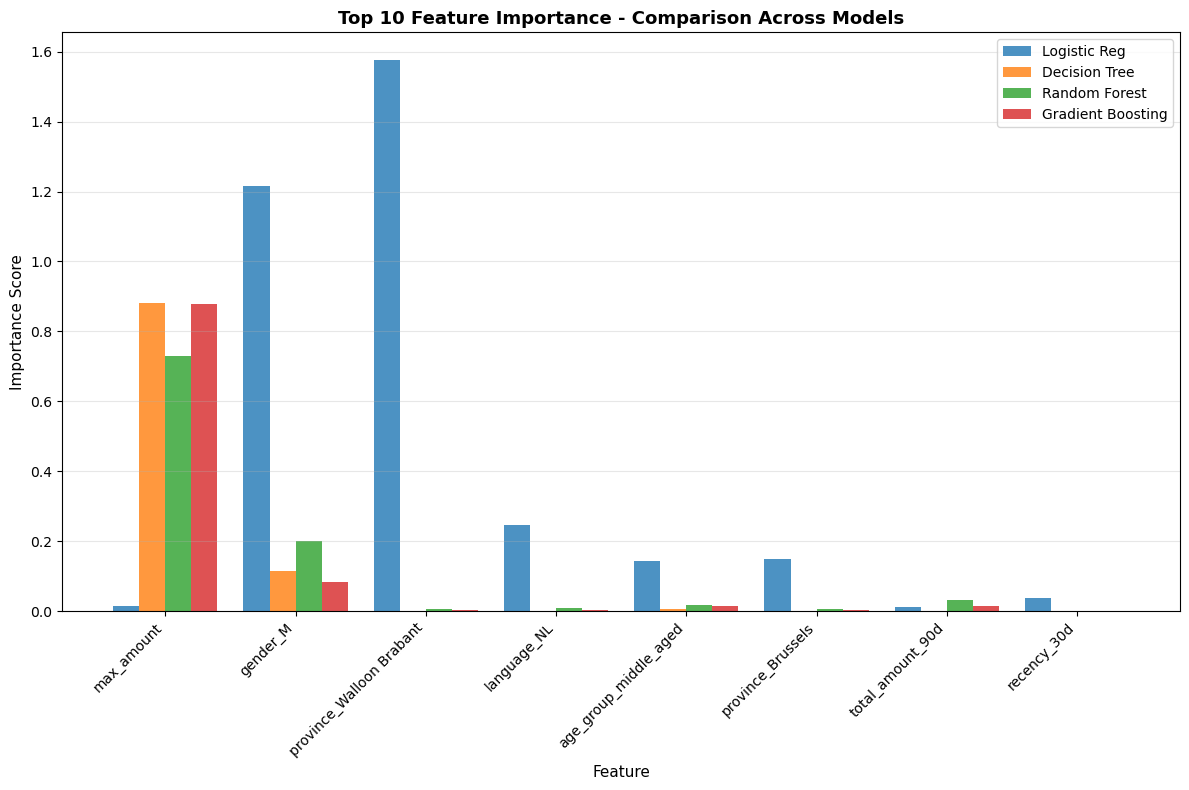

In [196]:
# ============================================
# FEATURE IMPORTANCE COMPARISON
# ============================================

# Combine feature importances from all models
feature_comparison = pd.DataFrame({
    'feature': features_to_use
})

# Add Logistic Regression coefficients (absolute value)
feature_comparison = feature_comparison.merge(
    feature_importance_lr[['feature', 'coefficient']].rename(columns={'coefficient': 'LR_coef'}),
    on='feature', how='left'
)
feature_comparison['LR_importance'] = feature_comparison['LR_coef'].abs()

# Add tree-based importances
feature_comparison = feature_comparison.merge(
    feature_importance_dt[['feature', 'importance']].rename(columns={'importance': 'DT_importance'}),
    on='feature', how='left'
)
feature_comparison = feature_comparison.merge(
    feature_importance_rf[['feature', 'importance']].rename(columns={'importance': 'RF_importance'}),
    on='feature', how='left'
)
feature_comparison = feature_comparison.merge(
    feature_importance_gb[['feature', 'importance']].rename(columns={'importance': 'GB_importance'}),
    on='feature', how='left'
)

# Calculate average importance rank
feature_comparison['avg_importance'] = feature_comparison[
    ['LR_importance', 'DT_importance', 'RF_importance', 'GB_importance']
].mean(axis=1)

feature_comparison = feature_comparison.sort_values('avg_importance', ascending=False)

print("="*60)
print("TOP 15 FEATURES - AVERAGE ACROSS ALL MODELS")
print("="*60)
print(feature_comparison[['feature', 'avg_importance']].head(15).to_string(index=False))

# Visualize top 10 features across all models
top_10_features = feature_comparison.head(10)

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top_10_features))
width = 0.2

ax.bar(x - 1.5*width, top_10_features['LR_importance'], width, label='Logistic Reg', alpha=0.8)
ax.bar(x - 0.5*width, top_10_features['DT_importance'], width, label='Decision Tree', alpha=0.8)
ax.bar(x + 0.5*width, top_10_features['RF_importance'], width, label='Random Forest', alpha=0.8)
ax.bar(x + 1.5*width, top_10_features['GB_importance'], width, label='Gradient Boosting', alpha=0.8)

ax.set_xlabel('Feature', fontsize=11)
ax.set_ylabel('Importance Score', fontsize=11)
ax.set_title('Top 10 Feature Importance - Comparison Across Models', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_10_features['feature'], rotation=45, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/h2/y6w_dvsj2mv412xb0cnmyvhc0000gn/T/ipykernel_32045/118499066.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([non_responders, responders], labels=['Non-responders', 'Responders'])


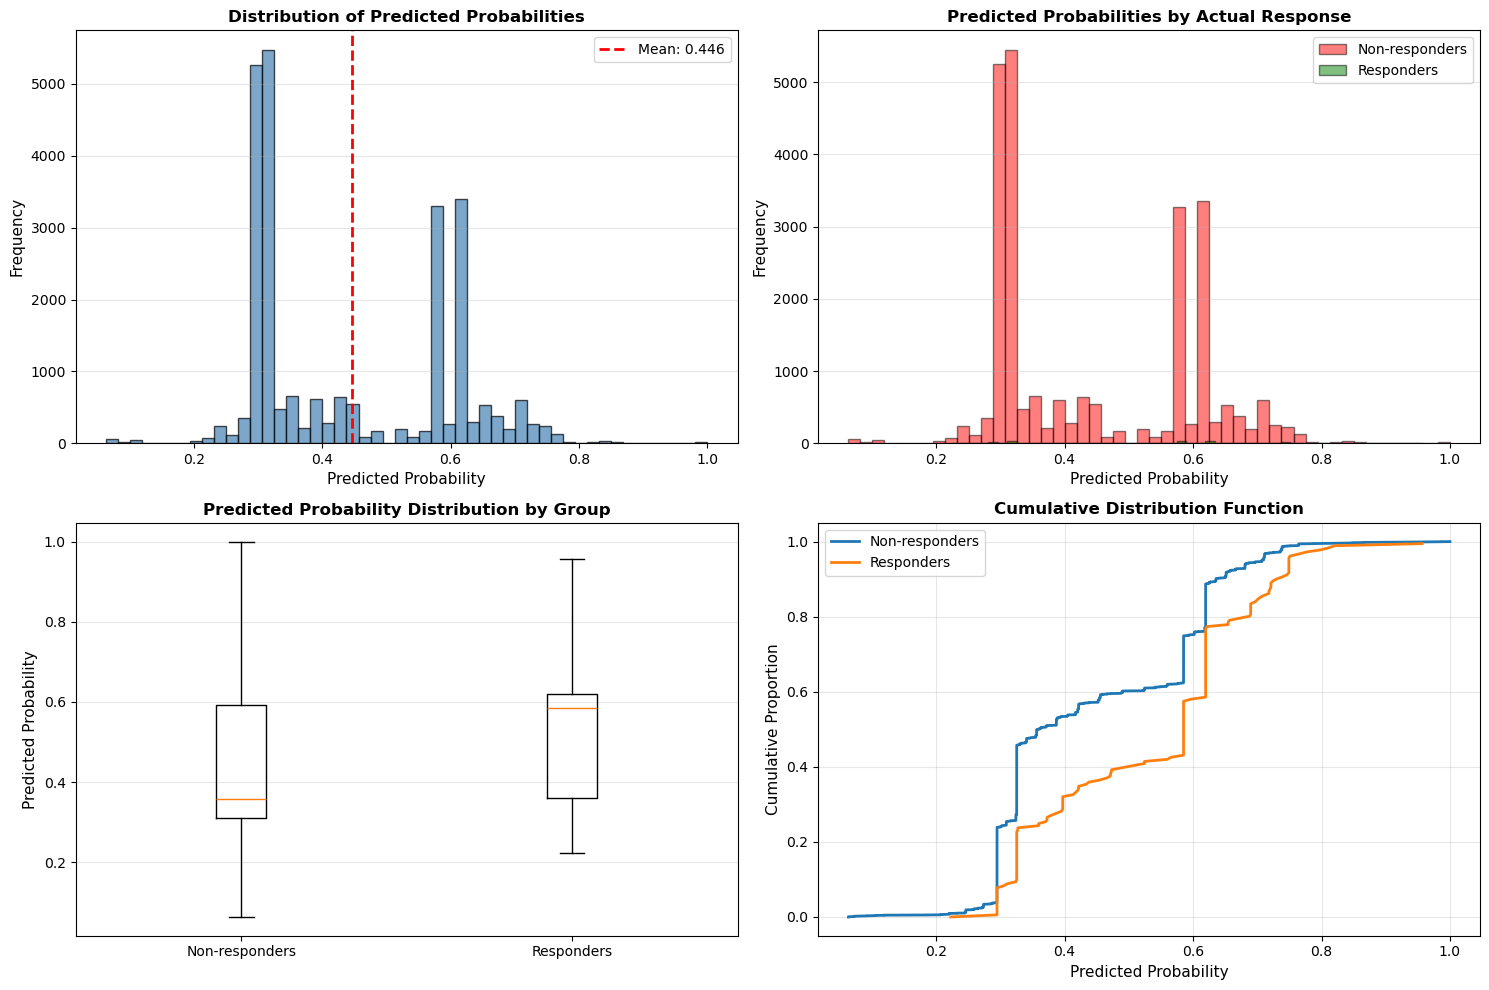

PREDICTION STATISTICS
Overall mean probability: 0.4464
Overall median probability: 0.3617
Overall std probability: 0.1570

Non-responders:
  Mean probability: 0.4458
  Median probability: 0.3585

Responders:
  Mean probability: 0.5291
  Median probability: 0.5852

Separation: 0.0832


In [197]:
# ============================================
# PREDICTION DISTRIBUTION ANALYSIS
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Distribution of predicted probabilities
axes[0, 0].hist(best_predictions, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Predicted Probability', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
axes[0, 0].axvline(x=best_predictions.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {best_predictions.mean():.3f}')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Distribution by actual target
responders = best_predictions[y_val == 1]
non_responders = best_predictions[y_val == 0]

axes[0, 1].hist(non_responders, bins=50, alpha=0.5, label='Non-responders', color='red', edgecolor='black')
axes[0, 1].hist(responders, bins=50, alpha=0.5, label='Responders', color='green', edgecolor='black')
axes[0, 1].set_xlabel('Predicted Probability', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Predicted Probabilities by Actual Response', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Box plot comparison
axes[1, 0].boxplot([non_responders, responders], labels=['Non-responders', 'Responders'])
axes[1, 0].set_ylabel('Predicted Probability', fontsize=11)
axes[1, 0].set_title('Predicted Probability Distribution by Group', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Cumulative distribution
sorted_non_resp = np.sort(non_responders)
sorted_resp = np.sort(responders)
axes[1, 1].plot(sorted_non_resp, np.arange(len(sorted_non_resp))/len(sorted_non_resp), 
               label='Non-responders', linewidth=2)
axes[1, 1].plot(sorted_resp, np.arange(len(sorted_resp))/len(sorted_resp), 
               label='Responders', linewidth=2)
axes[1, 1].set_xlabel('Predicted Probability', fontsize=11)
axes[1, 1].set_ylabel('Cumulative Proportion', fontsize=11)
axes[1, 1].set_title('Cumulative Distribution Function', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)
print("PREDICTION STATISTICS")
print("="*60)
print(f"Overall mean probability: {best_predictions.mean():.4f}")
print(f"Overall median probability: {np.median(best_predictions):.4f}")
print(f"Overall std probability: {best_predictions.std():.4f}")
print(f"\nNon-responders:")
print(f"  Mean probability: {non_responders.mean():.4f}")
print(f"  Median probability: {np.median(non_responders):.4f}")
print(f"\nResponders:")
print(f"  Mean probability: {responders.mean():.4f}")
print(f"  Median probability: {np.median(responders):.4f}")
print(f"\nSeparation: {responders.mean() - non_responders.mean():.4f}")

In [198]:
# ============================================
# CLASSIFICATION REPORTS - DIFFERENT THRESHOLDS
# ============================================

from sklearn.metrics import classification_report, confusion_matrix

thresholds = [0.3, 0.5, 0.7]

for threshold in thresholds:
    print("="*60)
    print(f"CLASSIFICATION REPORT - THRESHOLD = {threshold}")
    print("="*60)
    
    # Predict binary outcome
    y_pred_binary = (best_predictions >= threshold).astype(int)
    
    # Classification report
    print(classification_report(y_val, y_pred_binary, target_names=['Non-responder', 'Responder']))
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred_binary)
    print("Confusion Matrix:")
    print(f"                 Predicted")
    print(f"                 0      1")
    print(f"Actual  0     {cm[0,0]:5d}  {cm[0,1]:5d}")
    print(f"        1     {cm[1,0]:5d}  {cm[1,1]:5d}")
    
    # Additional metrics
    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    
    print(f"\nPrecision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Contacted: {(y_pred_binary == 1).sum()} donors ({(y_pred_binary == 1).sum()/len(y_pred_binary)*100:.1f}%)")
    print(f"Would respond: {cm[1,1]} donors\n")

CLASSIFICATION REPORT - THRESHOLD = 0.3
               precision    recall  f1-score   support

Non-responder       1.00      0.24      0.39     25455
    Responder       0.01      0.92      0.02       181

     accuracy                           0.24     25636
    macro avg       0.50      0.58      0.20     25636
 weighted avg       0.99      0.24      0.38     25636

Confusion Matrix:
                 Predicted
                 0      1
Actual  0      6107  19348
        1        15    166

Precision: 0.009
Recall: 0.917
Contacted: 19514 donors (76.1%)
Would respond: 166 donors

CLASSIFICATION REPORT - THRESHOLD = 0.5
               precision    recall  f1-score   support

Non-responder       1.00      0.60      0.75     25455
    Responder       0.01      0.60      0.02       181

     accuracy                           0.60     25636
    macro avg       0.50      0.60      0.39     25636
 weighted avg       0.99      0.60      0.75     25636

Confusion Matrix:
                 Pre

# Testing The Model

In [ ]:
# ============================================
# LOAD CAMPAIGN 7362 (SCORING DATASET)
# ============================================

# Load selection campaign 7362
sc_7362 = pd.read_csv('../data/raw/selection campaign 7362.csv')

print("="*60)
print("CAMPAIGN 7362 - SCORING DATASET")
print("="*60)
print(f"Total donors to score: {len(sc_7362):,}")
print(f"\nFirst few donors:")
print(sc_7362.head())

# Date for this campaign
campaign_date_7362 = pd.to_datetime('2020-02-01')
print(f"\nCampaign date: {campaign_date_7362.date()}")

# Feature cutoff (30 days before)
#feature_cutoff_7362 = campaign_date_7362 - timedelta(days=gap_days)
#print(f"Feature cutoff date: {feature_cutoff_7362.date()}")
#print(f"Gap: {gap_days} days")

CAMPAIGN 7362 - SCORING DATASET
Total donors to score: 26,522

First few donors:
   donorID
0  D134242
1  D126503
2  D104392
3  D105905
4  D120506

Campaign date: 2020-02-01
Feature cutoff date: 2020-01-25
Gap: 7 days


In [201]:
# ============================================
# BUILD BASETABLE FOR CAMPAIGN 7362
# ============================================

print("Building features for campaign 7362...")
print("This will take a few minutes...\n")

# Start with donor list
basetable_7362 = sc_7362.copy()

# Set donorID as index
basetable_7362 = basetable_7362.set_index('donorID')

# Merge demographics
basetable_7362 = basetable_7362.merge(donors.set_index('donorID'), 
                                       left_index=True, right_index=True, how='left')

# Calculate age at feature cutoff
basetable_7362['age'] = (campaign_date_7362- basetable_7362['dateOfBirth']).dt.days / 365.25

# One-hot encode province, region, gender, language
basetable_7362 = pd.get_dummies(basetable_7362, columns=['province', 'region', 'gender', 'language'], 
                                 drop_first=True)

print(f"✓ Demographics added. Shape: {basetable_7362.shape}")

# NOW BUILD ALL THE DONATION HISTORY FEATURES
# (Use the EXACT same logic as training, but with feature_cutoff_7362)

Building features for campaign 7362...
This will take a few minutes...

✓ Demographics added. Shape: (26522, 19)


In [ ]:
# ============================================
# HISTORICAL FEATURES - CAMPAIGN 7362
# ============================================

# Filter historical gifts (BEFORE feature cutoff)
historical_7362 = gifts[
    (gifts['donorID'].isin(basetable_7362.index)) & 
    (gifts['gift_date'] < feature_cutoff_7362)
].copy()

print(f"Historical donations: {len(historical_7362):,}")
print(f"Date range: {historical_7362['gift_date'].min()} to {historical_7362['gift_date'].max()}")

# Verify no data leakage
assert historical_7362['gift_date'].max() < feature_cutoff_7362, "⚠️ DATA LEAKAGE!"
print("✓ No data leakage\n")

# Create spontaneous flag
historical_7362['is_spontaneous'] = historical_7362['campaignID'].isna().astype(int)

# Calculate all the same features as training
# I'll show the key ones - you should add ALL features from your training set

# --- LIFETIME STATS ---
lifetime_7362 = historical_7362.groupby('donorID').agg({
    'amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
    'gift_date': ['min', 'max']
}).reset_index()
lifetime_7362.columns = ['donorID', 'frequency', 'total_amount', 'avg_amount', 
                         'std_amount', 'min_amount', 'max_amount', 
                         'first_donation_date', 'last_donation_date']

# Recency
lifetime_7362['recency_days'] = (feature_cutoff_7362 - lifetime_7362['last_donation_date']).dt.days

# Length of relationship (LOR)
lifetime_7362['LOR'] = (lifetime_7362['last_donation_date'] - lifetime_7362['first_donation_date']).dt.days

# Set donorID as index and drop date columns
lifetime_7362 = lifetime_7362.set_index('donorID').drop(columns=['first_donation_date', 'last_donation_date'])

# Merge
basetable_7362 = basetable_7362.merge(lifetime_7362, left_index=True, right_index=True, how='left')

print(f"✓ Lifetime features added. Shape: {basetable_7362.shape}")